In [1]:
import numpy as np
import gstools as gs
import xarray as xr
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import tqdm
import seaborn as sns
sns.set_context("talk")

/vols/satellite/home/lenk/anaconda3/envs/tracking/lib/python3.7/site-packages/xarray/core/merge.py:17: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)
/vols/satellite/home/lenk/anaconda3/envs/tracking/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
with xr.open_dataset("/vols/satellite/home/lenk/data/HACI_track_data/track_20130618_2687.nc") as file:
    ir108 = file.ir108.data.copy()
    hrv = file.hrv.data.copy()
    cma = file.cma.data.copy()

## 1. Empirisches Variogramm bestimmen

In [5]:
x_u, y_u = np.meshgrid(np.arange(0,51,1), np.arange(0,51,1))

In [6]:
bins = np.arange(0, 25, 1)
bin_center, gamma = gs.vario_estimate_unstructured(
    (x_u, y_u),
    (300-ir108[6]).flatten(),
    bins,
    sampling_size=2000,
    sampling_seed=19920516,
)

In [7]:
# fit an exponential model
fit_model = gs.Spherical(dim=2)
fit_model.fit_variogram(bin_center, gamma, nugget=False)

({'var': 79.46773218404087, 'len_scale': 14.18932783068751, 'nugget': 0.0},
 array([[2.3807906 , 0.63831113],
        [0.63831113, 0.52105703]]))

In [8]:
print(fit_model.variogram(50))

79.46773218404087


/vols/satellite/home/lenk/anaconda3/envs/tracking/lib/python3.7/site-packages/gstools/covmodel/plot.py:121: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


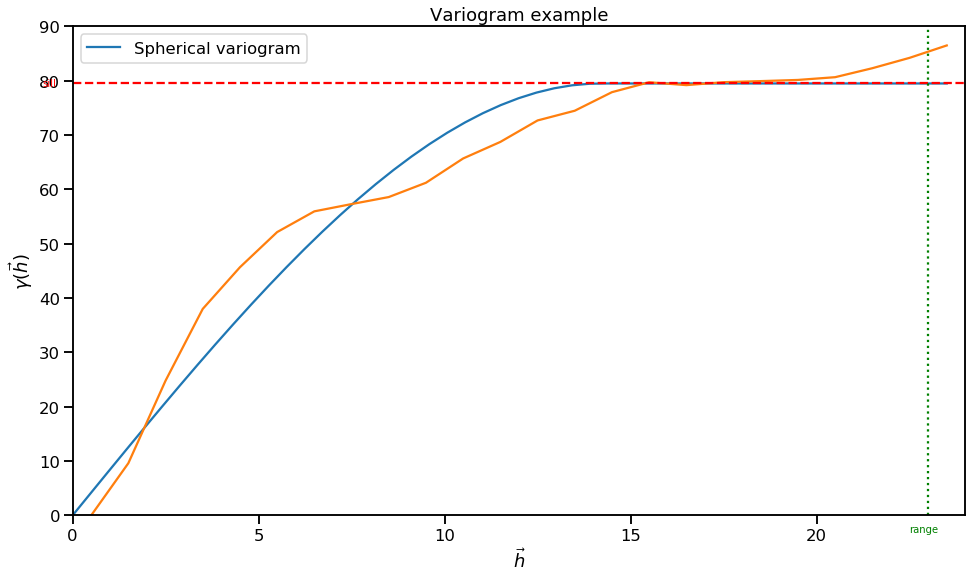

In [9]:
fig,ax = plt.subplots(1,1,figsize=(16,9))
ax = fit_model.plot(x_max=max(bin_center),ax=ax)
ax.plot(bin_center, gamma)
ax.set_xlabel(r"$\vec{h}$")
ax.set_ylabel(r"$\gamma(\vec{h})$")
ax.axhline(fit_model.variogram(23),color='red',linestyle='dashed')
ax.axvline(23,color='green',linestyle='dotted')
ax.set_xlim(0,24)
ax.set_title("Variogram example")
ax.set_ylim(0,90)
ax.text(-0.8,fit_model.variogram(23)-0.5, "sill",color='red')
ax.text(22.5,-3, "range",color='green')
plt.savefig("/vols/satellite/home/lenk/notebooks/Vorträge/Doktorandenvortrag3/variogram.pdf",bbox_inches='tight')

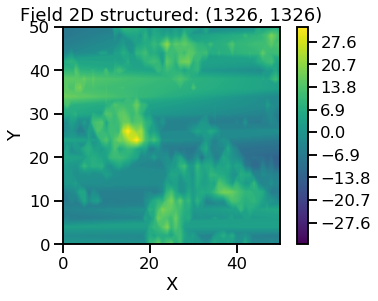

In [11]:
srf = gs.SRF(fit_model)
srf.structured([x_u[::2], y_u[::2]])
ax = srf.plot()
ax.set_aspect("equal")

In [12]:
fig,ax = plt.subplots(1,1,figsize=(5,5))
ax.imshow(300-ir108[6])
ax.set_apsect("equal)

SyntaxError: EOL while scanning string literal (<ipython-input-12-8b8e64643a35>, line 3)

In [9]:
x_s_skip = np.ravel(x_u)
y_s_skip = np.ravel(y_u)

In [10]:
gamma_x = gs.vario_estimate_structured(ir108[6], direction="x")
gamma_y = gs.vario_estimate_structured(ir108[6], direction="y")


In [11]:
ir108[6].shape

(51, 51)

In [12]:
x_plot = x_s_skip[:26]
y_plot = y_s_skip[:26]

In [13]:
gamma_y

array([ 0.        ,  5.45395842, 16.86641368, 28.11764934, 36.49392022,
       41.29739213, 43.40653821, 43.3450467 , 41.35851354, 38.55691438,
       36.66149995, 37.82207026, 42.1599233 , 47.73015291, 52.16155361,
       53.95009408, 52.19532921, 49.66237445, 49.32816148, 50.38378812,
       52.2678804 , 54.32165449, 56.76545742, 59.1898474 , 59.70200571,
       52.62687915, 40.46166932, 31.75343299, 30.69572557, 31.75615801,
       33.02146319, 33.88491132, 34.55748105, 34.29705964, 32.15463331,
       25.3288212 , 16.6658181 ,  9.94457797,  4.96556639,  2.64028374,
        2.43050423,  2.38025519,  2.08482668,  1.8215662 ,  1.28307427,
        0.83248589,  0.89725443,  1.00990329,  1.20208509,  1.37388401,
        1.86398797])

In [14]:
fit_model_x = gs.Exponential(dim=2)
fit_model_x.fit_variogram(x_plot, gamma_x[:26], nugget=False)
fit_model_y = gs.Exponential(dim=2)
fit_model_y.fit_variogram(y_plot, gamma_y[:26], nugget=False)

({'var': 1.0, 'len_scale': 1.0, 'nugget': 0.0}, array([[0., 0.],
        [0., 0.]]))

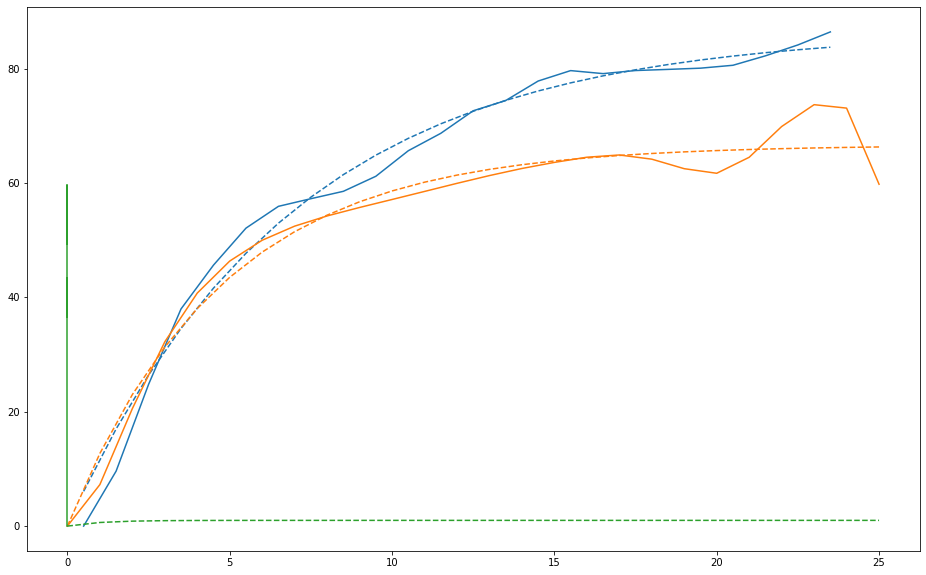

In [16]:
plt.figure(figsize=(16,10)) # new figure
line, = plt.plot(bin_center, gamma, label="estimated variogram (isotropic)")
plt.plot(
bin_center,
fit_model.variogram(bin_center),
color=line.get_color(),
linestyle="--",
label="exp. variogram (isotropic)",
)
line, = plt.plot(x_plot, gamma_x[:26], label="estimated variogram in x-dir")
plt.plot(
x_plot,
fit_model_x.variogram(x_plot),
color=line.get_color(),
linestyle="--",
label="exp. variogram in x-dir",
)
line, = plt.plot(y_plot, gamma_y[:26], label="estimated variogram in y-dir")
plt.plot(
x_plot,
fit_model_y.variogram(x_plot),
color=line.get_color(),
linestyle="--",
label="exp. variogram in y-dir",
)


In [ ]:
print("semivariogram model (isotropic):\n", fit_model)
print("semivariogram model (in x-dir.):\n", fit_model_x)
print("semivariogram model (in y-dir.):\n", fit_model_y)

In [15]:
import glob
import tqdm

In [16]:
tracks = glob.glob("/vols/satellite/home/lenk/data/HACI_track_data/track_2013*.nc") + glob.glob("/vols/satellite/home/lenk/data/HACI_track_data/track_2012*.nc") + glob.glob("/vols/satellite/home/lenk/data/HACI_track_data/track_2014*.nc")

In [19]:
len(tracks)

2920

In [19]:
bins = np.arange(0, 25, 1)

In [20]:
sills = []
lengths = []
cloudiness = []
track_ids = []

In [21]:
for i, tr in tqdm.tqdm(enumerate(tracks),total=len(tracks)):
    try:
        with xr.open_dataset(tr) as file:
            ir108 = file.ir108.data.copy()
            cma = file.cma.data.copy()

        bin_center, gamma = gs.vario_estimate_unstructured(
            (x_u, y_u),
            ir108[6].flatten(),
            bins,
            sampling_size=2000
            )

        fit_model = gs.Exponential(dim=2)
        fit_model.fit_variogram(bin_center, gamma, nugget=False)

        sills.append(fit_model.var)
        lengths.append(fit_model.len_scale)
        cloudiness.append(1-(len(np.where(cma[6]<2)[0]) / 51**2))
        track_ids.append(tr.split("/")[-1][6:-2])
    except:
        continue

100%|██████████| 1014/1014 [57:37<00:00,  3.41s/it]


In [353]:
ir108_min = []
ir108_mean = []

In [354]:
for i, tr in tqdm.tqdm(enumerate(tracks),total=len(tracks)):
    try:
        with xr.open_dataset(tr) as file:
            ir108 = file.ir108.data.copy()
            
        ir108_min.append(np.min(ir108[6]))  
        ir108_mean.append(np.mean(ir108[6]))
    except:
        continue





  0%|          | 0/2920 [00:00<?, ?it/s]



  0%|          | 2/2920 [00:00<06:12,  7.84it/s]



  0%|          | 6/2920 [00:00<05:32,  8.77it/s]



  0%|          | 7/2920 [00:00<06:02,  8.04it/s]



  0%|          | 8/2920 [00:00<06:26,  7.53it/s]



  0%|          | 9/2920 [00:01<07:08,  6.79it/s]



  0%|          | 11/2920 [00:01<06:35,  7.36it/s]



  0%|          | 12/2920 [00:01<07:30,  6.46it/s]



  0%|          | 13/2920 [00:01<07:41,  6.29it/s]



  1%|          | 16/2920 [00:01<06:26,  7.51it/s]



  1%|          | 17/2920 [00:02<06:49,  7.09it/s]



  1%|          | 18/2920 [00:02<06:25,  7.52it/s]



  1%|          | 21/2920 [00:02<05:04,  9.51it/s]



  1%|          | 23/2920 [00:02<04:51,  9.95it/s]



  1%|          | 25/2920 [00:02<04:43, 10.22it/s]



  1%|          | 27/2920 [00:02<04:04, 11.81it/s]



  1%|          | 29/2920 [00:02<04:18, 11.18it/s]



  1%|          | 31/2920 [00:03<05:16,  9.13it/s]



  1%|          | 33/2920 [00:03<05:34,  8.63it/s]



  1

 13%|█▎        | 379/2920 [00:56<07:49,  5.42it/s]



 13%|█▎        | 380/2920 [00:56<07:55,  5.34it/s]



 13%|█▎        | 381/2920 [00:56<07:52,  5.38it/s]



 13%|█▎        | 382/2920 [00:56<08:51,  4.78it/s]



 13%|█▎        | 383/2920 [00:56<07:49,  5.41it/s]



 13%|█▎        | 384/2920 [00:56<07:38,  5.54it/s]



 13%|█▎        | 386/2920 [00:57<06:52,  6.14it/s]



 13%|█▎        | 388/2920 [00:57<05:36,  7.53it/s]



 13%|█▎        | 391/2920 [00:57<04:58,  8.48it/s]



 13%|█▎        | 393/2920 [00:57<04:31,  9.31it/s]



 14%|█▎        | 395/2920 [00:57<04:17,  9.81it/s]



 14%|█▎        | 397/2920 [00:58<04:41,  8.97it/s]



 14%|█▎        | 399/2920 [00:58<04:33,  9.23it/s]



 14%|█▎        | 401/2920 [00:58<04:37,  9.07it/s]



 14%|█▍        | 402/2920 [00:58<05:53,  7.12it/s]



 14%|█▍        | 403/2920 [00:59<06:17,  6.67it/s]



 14%|█▍        | 404/2920 [00:59<06:31,  6.43it/s]



 14%|█▍        | 405/2920 [00:59<06:56,  6.04it/s]



 14%|█▍        | 406/2920 [0

 25%|██▌       | 738/2920 [01:51<05:56,  6.12it/s]



 25%|██▌       | 739/2920 [01:51<06:24,  5.67it/s]



 25%|██▌       | 740/2920 [01:51<06:23,  5.69it/s]



 25%|██▌       | 741/2920 [01:51<06:15,  5.81it/s]



 25%|██▌       | 743/2920 [01:52<05:31,  6.56it/s]



 25%|██▌       | 744/2920 [01:52<06:09,  5.90it/s]



 26%|██▌       | 746/2920 [01:52<05:24,  6.71it/s]



 26%|██▌       | 748/2920 [01:52<05:13,  6.93it/s]



 26%|██▌       | 750/2920 [01:53<04:54,  7.37it/s]



 26%|██▌       | 751/2920 [01:53<05:33,  6.50it/s]



 26%|██▌       | 752/2920 [01:53<07:21,  4.91it/s]



 26%|██▌       | 754/2920 [01:53<05:59,  6.03it/s]



 26%|██▌       | 755/2920 [01:53<06:15,  5.77it/s]



 26%|██▌       | 756/2920 [01:54<06:34,  5.49it/s]



 26%|██▌       | 757/2920 [01:54<07:17,  4.94it/s]



 26%|██▌       | 759/2920 [01:54<07:18,  4.93it/s]



 26%|██▌       | 760/2920 [01:54<06:44,  5.34it/s]



 26%|██▌       | 761/2920 [01:55<05:59,  6.00it/s]



 26%|██▌       | 762/2920 [0

 38%|███▊      | 1111/2920 [02:44<05:27,  5.53it/s]



 38%|███▊      | 1112/2920 [02:45<05:28,  5.50it/s]



 38%|███▊      | 1114/2920 [02:45<05:21,  5.62it/s]



 38%|███▊      | 1115/2920 [02:45<05:34,  5.40it/s]



 38%|███▊      | 1117/2920 [02:45<04:50,  6.21it/s]



 38%|███▊      | 1118/2920 [02:46<05:19,  5.64it/s]



 38%|███▊      | 1119/2920 [02:46<04:49,  6.23it/s]



 38%|███▊      | 1120/2920 [02:46<05:34,  5.38it/s]



 38%|███▊      | 1121/2920 [02:46<05:41,  5.27it/s]



 38%|███▊      | 1123/2920 [02:46<05:04,  5.91it/s]



 38%|███▊      | 1124/2920 [02:47<05:01,  5.96it/s]



 39%|███▊      | 1125/2920 [02:47<05:23,  5.55it/s]



 39%|███▊      | 1126/2920 [02:47<05:21,  5.58it/s]



 39%|███▊      | 1128/2920 [02:47<04:42,  6.35it/s]



 39%|███▊      | 1129/2920 [02:47<05:13,  5.72it/s]



 39%|███▊      | 1130/2920 [02:47<04:57,  6.02it/s]



 39%|███▊      | 1131/2920 [02:48<05:33,  5.36it/s]



 39%|███▉      | 1132/2920 [02:48<05:54,  5.04it/s]



 39%|███▉ 

 50%|█████     | 1463/2920 [03:34<03:21,  7.21it/s]



 50%|█████     | 1464/2920 [03:34<03:27,  7.02it/s]



 50%|█████     | 1465/2920 [03:35<03:48,  6.36it/s]



 50%|█████     | 1466/2920 [03:35<03:53,  6.23it/s]



 50%|█████     | 1467/2920 [03:35<04:13,  5.73it/s]



 50%|█████     | 1468/2920 [03:35<04:06,  5.89it/s]



 50%|█████     | 1471/2920 [03:35<03:34,  6.75it/s]



 50%|█████     | 1472/2920 [03:36<04:27,  5.42it/s]



 51%|█████     | 1475/2920 [03:36<03:36,  6.67it/s]



 51%|█████     | 1477/2920 [03:36<03:18,  7.27it/s]



 51%|█████     | 1478/2920 [03:37<05:37,  4.27it/s]



 51%|█████     | 1479/2920 [03:37<05:13,  4.59it/s]



 51%|█████     | 1481/2920 [03:37<04:44,  5.06it/s]



 51%|█████     | 1482/2920 [03:37<04:32,  5.28it/s]



 51%|█████     | 1483/2920 [03:37<04:32,  5.26it/s]



 51%|█████     | 1484/2920 [03:38<04:15,  5.61it/s]



 51%|█████     | 1485/2920 [03:38<04:13,  5.67it/s]



 51%|█████     | 1487/2920 [03:38<03:20,  7.16it/s]



 51%|█████

 62%|██████▏   | 1809/2920 [04:24<02:12,  8.37it/s]



 62%|██████▏   | 1811/2920 [04:25<02:21,  7.84it/s]



 62%|██████▏   | 1813/2920 [04:26<05:29,  3.35it/s]



 62%|██████▏   | 1814/2920 [04:26<05:29,  3.35it/s]



 62%|██████▏   | 1815/2920 [04:27<05:23,  3.41it/s]



 62%|██████▏   | 1816/2920 [04:27<05:18,  3.46it/s]



 62%|██████▏   | 1817/2920 [04:27<04:34,  4.02it/s]



 62%|██████▏   | 1819/2920 [04:27<03:29,  5.26it/s]



 62%|██████▏   | 1820/2920 [04:27<03:15,  5.62it/s]



 62%|██████▏   | 1823/2920 [04:27<02:42,  6.74it/s]



 62%|██████▏   | 1824/2920 [04:28<02:59,  6.09it/s]



 63%|██████▎   | 1826/2920 [04:28<02:24,  7.57it/s]



 63%|██████▎   | 1828/2920 [04:28<02:38,  6.89it/s]



 63%|██████▎   | 1830/2920 [04:28<02:18,  7.87it/s]



 63%|██████▎   | 1832/2920 [04:29<02:10,  8.32it/s]



 63%|██████▎   | 1834/2920 [04:29<02:15,  8.04it/s]



 63%|██████▎   | 1835/2920 [04:29<02:59,  6.05it/s]



 63%|██████▎   | 1836/2920 [04:29<03:02,  5.93it/s]



 63%|█████

 73%|███████▎  | 2128/2920 [05:22<02:27,  5.37it/s]



 73%|███████▎  | 2130/2920 [05:22<02:11,  6.00it/s]



 73%|███████▎  | 2131/2920 [05:23<02:21,  5.57it/s]



 73%|███████▎  | 2133/2920 [05:23<01:51,  7.07it/s]



 73%|███████▎  | 2135/2920 [05:23<01:41,  7.70it/s]



 73%|███████▎  | 2136/2920 [05:23<01:57,  6.68it/s]



 73%|███████▎  | 2137/2920 [05:23<02:00,  6.52it/s]



 73%|███████▎  | 2138/2920 [05:24<01:57,  6.67it/s]



 73%|███████▎  | 2139/2920 [05:24<02:15,  5.77it/s]



 73%|███████▎  | 2140/2920 [05:24<02:15,  5.74it/s]



 73%|███████▎  | 2142/2920 [05:24<02:04,  6.23it/s]



 73%|███████▎  | 2143/2920 [05:24<02:07,  6.09it/s]



 73%|███████▎  | 2145/2920 [05:25<02:15,  5.74it/s]



 73%|███████▎  | 2146/2920 [05:25<02:21,  5.46it/s]



 74%|███████▎  | 2147/2920 [05:25<02:13,  5.81it/s]



 74%|███████▎  | 2148/2920 [05:25<02:10,  5.91it/s]



 74%|███████▎  | 2149/2920 [05:26<02:35,  4.96it/s]



 74%|███████▎  | 2150/2920 [05:26<02:31,  5.07it/s]



 74%|█████

 83%|████████▎ | 2431/2920 [06:15<01:44,  4.70it/s]



 83%|████████▎ | 2432/2920 [06:15<01:46,  4.59it/s]



 83%|████████▎ | 2434/2920 [06:15<01:33,  5.19it/s]



 83%|████████▎ | 2436/2920 [06:15<01:22,  5.86it/s]



 83%|████████▎ | 2438/2920 [06:16<01:10,  6.79it/s]



 84%|████████▎ | 2440/2920 [06:16<01:09,  6.92it/s]



 84%|████████▎ | 2441/2920 [06:16<01:17,  6.16it/s]



 84%|████████▎ | 2442/2920 [06:16<01:30,  5.31it/s]



 84%|████████▎ | 2443/2920 [06:17<01:30,  5.28it/s]



 84%|████████▎ | 2444/2920 [06:17<01:34,  5.04it/s]



 84%|████████▎ | 2445/2920 [06:17<01:36,  4.90it/s]



 84%|████████▍ | 2447/2920 [06:17<01:20,  5.86it/s]



 84%|████████▍ | 2448/2920 [06:17<01:16,  6.15it/s]



 84%|████████▍ | 2449/2920 [06:17<01:18,  5.96it/s]



 84%|████████▍ | 2450/2920 [06:18<01:16,  6.11it/s]



 84%|████████▍ | 2451/2920 [06:18<01:27,  5.38it/s]



 84%|████████▍ | 2453/2920 [06:18<01:12,  6.43it/s]



 84%|████████▍ | 2454/2920 [06:18<01:16,  6.05it/s]



 84%|█████

 93%|█████████▎| 2729/2920 [07:08<00:32,  5.86it/s]



 93%|█████████▎| 2730/2920 [07:08<00:28,  6.63it/s]



 94%|█████████▎| 2731/2920 [07:08<00:32,  5.77it/s]



 94%|█████████▎| 2732/2920 [07:08<00:39,  4.76it/s]



 94%|█████████▎| 2733/2920 [07:09<00:37,  4.92it/s]



 94%|█████████▎| 2735/2920 [07:09<00:32,  5.72it/s]



 94%|█████████▎| 2736/2920 [07:09<00:29,  6.15it/s]



 94%|█████████▎| 2737/2920 [07:09<00:31,  5.75it/s]



 94%|█████████▍| 2738/2920 [07:09<00:31,  5.74it/s]



 94%|█████████▍| 2739/2920 [07:09<00:31,  5.68it/s]



 94%|█████████▍| 2740/2920 [07:10<00:33,  5.31it/s]



 94%|█████████▍| 2742/2920 [07:10<00:29,  5.99it/s]



 94%|█████████▍| 2744/2920 [07:10<00:27,  6.39it/s]



 94%|█████████▍| 2746/2920 [07:10<00:25,  6.85it/s]



 94%|█████████▍| 2747/2920 [07:11<00:28,  6.14it/s]



 94%|█████████▍| 2748/2920 [07:11<00:27,  6.27it/s]



 94%|█████████▍| 2749/2920 [07:11<00:24,  7.02it/s]



 94%|█████████▍| 2750/2920 [07:11<00:25,  6.55it/s]



 94%|█████

In [276]:
CT = []
#tr = []

In [277]:
for i, tr in tqdm.tqdm(enumerate(tracks),total=len(tracks)):
    try:
        with xr.open_dataset(tr) as file:
            ct = file.ct.data.copy()[6]
            cma = file.cma.data.copy()[6]
        
        ct_count = np.unique(ct[ct>1],return_counts=True)
        
        CT.append(ct_count[0][np.where(ct_count[1]==np.max(ct_count[1]))[0][0]]) 
        #tr.extend([tr.split("/")[-1][6:-2]]*len(ct[6]))
    except:
        continue

100%|██████████| 2920/2920 [02:17<00:00, 21.22it/s]


In [74]:
from scipy.cluster.hierarchy import dendrogram, linkage

In [75]:
import pandas as pd

In [26]:
sill_df = pd.DataFrame({'sill':sills,
                        'len':lengths,
                        'cl':cloudiness,
                        'id':track_ids})

In [273]:
sill_df.to_csv("/vols/satellite/home/lenk/proj/2019-01_trackingstudie/data/geostat_values.csv",index=False,float_format="%.3f")

In [355]:
sill_df = sill_df.assign(ir108_min = ir108_min,
                         ir108_mean = ir108_mean,
                         ct = CT)

In [117]:
sill_df.year.unique()

array([2013, 2014, 2012])

In [274]:
sill_df = pd.read_csv("/vols/satellite/home/lenk/proj/2019-01_trackingstudie/data/geostat_values.csv")

In [275]:
sill_df.describe()

sill           len           cl      cluster         year  \
count  2.760000e+03  2.760000e+03  2760.000000  2760.000000  2760.000000   
mean   7.253572e+05  4.316489e+04     0.870047     1.634783  2012.795652   
std    3.955686e+06  1.743786e+05     0.168226     0.481578     0.785135   
min    1.164000e+00  2.500000e+00     0.000000     1.000000  2012.000000   
25%    9.436500e+01  7.480750e+00     0.825000     1.000000  2012.000000   
50%    2.107875e+02  1.258300e+01     0.935000     2.000000  2013.000000   
75%    6.180878e+02  3.463275e+01     0.987000     2.000000  2013.000000   
max    1.061304e+08  3.175236e+06     1.000000     2.000000  2014.000000   

         ir108_min           ct   ir108_mean    lightning  
count  2760.000000  2760.000000  2760.000000  2760.000000  
mean    229.570495    12.237681   264.949098     0.524275  
std      13.840974     4.520024    13.840070     0.499501  
min     201.839000     2.000000   215.131000     0.000000  
25%     219.279000     8.000000   256.075250     0.000000  
50%     227.118000    12.000000   266.681000     1.000000  
75%     237.060000    17.000000   275.054000     1.000000  
max     289.804000    19.000000   300.568000     1.000000

In [125]:
year  = [int(tr.id[0:4]) for i, tr in sill_df.iterrows()]

In [126]:
sill_df = sill_df.assign(year=year)

In [205]:
sill_df.to_csv("/vols/satellite/home/lenk/proj/2019-01_trackingstudie/data/geostat_values.csv",index=False,float_format="%.3f")

In [234]:
# sill_df = sill_df.assign(lightning = sill_df.lightning.replace(1,'yes'))
# sill_df = sill_df.assign(lightning = sill_df.lightning.replace(0,'no'))

In [235]:
sill_df.year.unique()

array([2013, 2014, 2012])

In [362]:
import seaborn as sns
sns.set_context("talk")

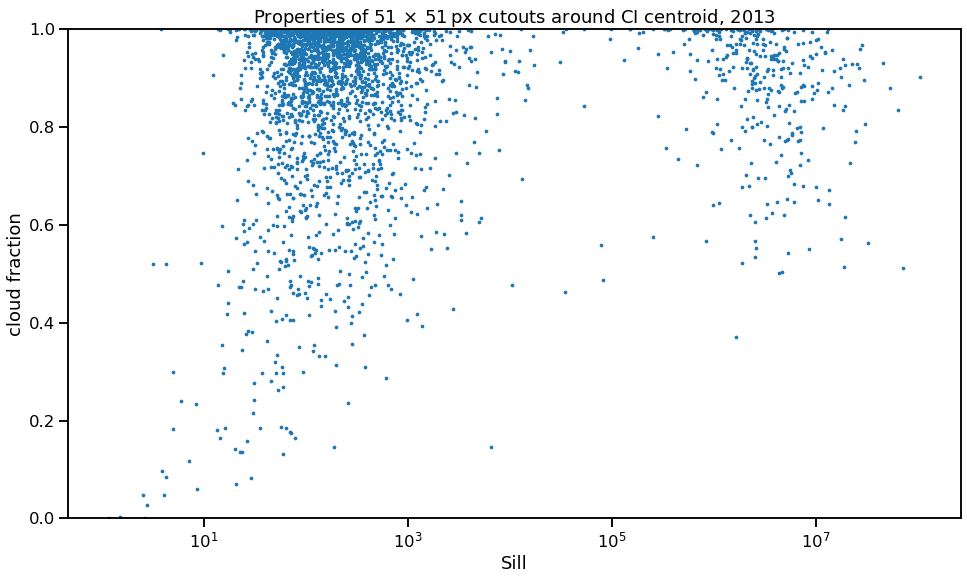

In [363]:
fig,ax = plt.subplots(1,1,figsize=(16,9))
ax.scatter(sill_df.sill,sill_df.cl,s=5)
ax.set_xscale("log")
#ax.set_yscale("log")
ax.set_xlabel(u"Sill")
ax.set_ylabel("cloud fraction")
ax.set_ylim(0,1)
ax.set_title(r"Properties of $51\,\times\,51\,$px cutouts around CI centroid, 2013")
plt.savefig("/vols/satellite/home/lenk/notebooks/Vorträge/Doktorandenvortrag3/sill_cf.pdf",bbox_inches='tight')

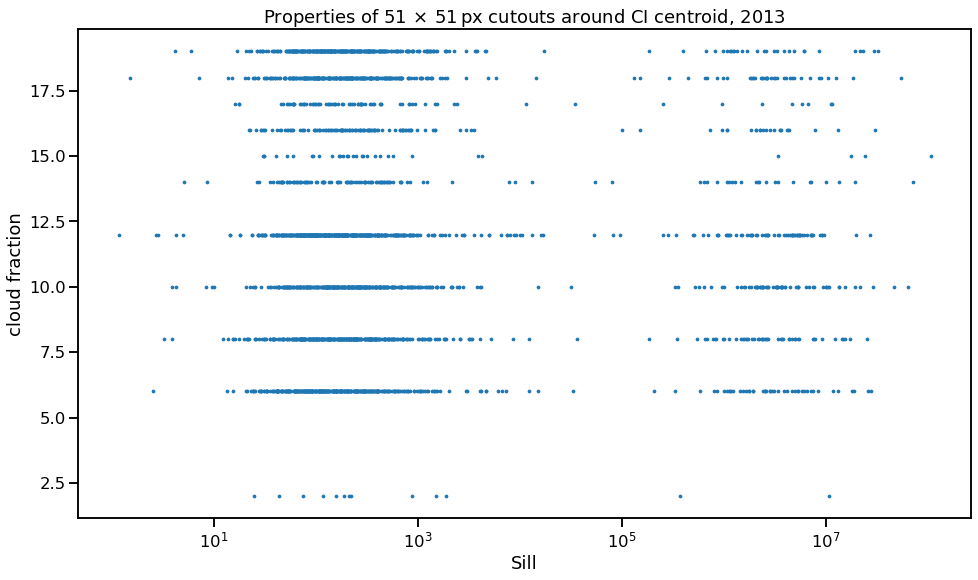

In [303]:
fig,ax = plt.subplots(1,1,figsize=(16,9))
ax.scatter(sill_df.sill,sill_df.ct,s=5)
ax.set_xscale("log")
#ax.set_yscale("log")
ax.set_xlabel(u"Sill")
ax.set_ylabel("cloud fraction")
#ax.set_ylim(0,1)
ax.set_title(r"Properties of $51\,\times\,51\,$px cutouts around CI centroid, 2013")
plt.savefig("/vols/satellite/home/lenk/notebooks/Vorträge/Doktorandenvortrag3/sill_ct.pdf",bbox_inches='tight')

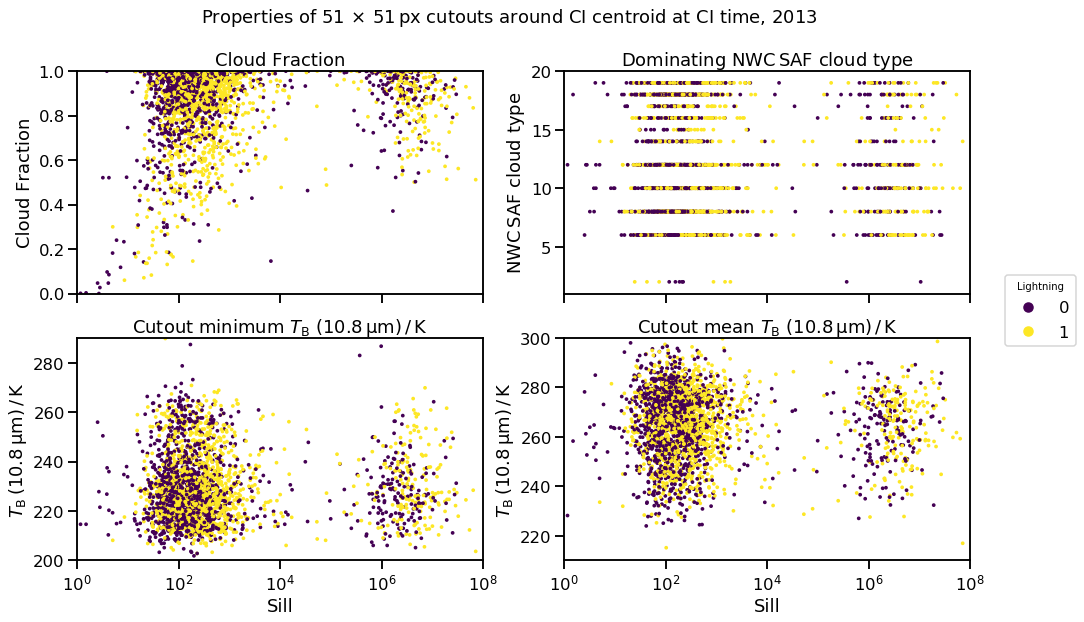

In [239]:
fig,ax = plt.subplots(2,2,figsize=(16,9),sharex=True)
axs = ax.ravel()
axs[0].scatter(sill_df.sill,sill_df.cl,s=5,c=sill_df.lightning)
axs[0].set_xscale("log")
axs[0].set_ylabel("Cloud Fraction")
axs[0].set_title("Cloud Fraction")
axs[0].set_xlim(1,1e8)
axs[0].set_ylim(0,1)

axs[1].scatter(sill_df.sill,sill_df.ct,s=5,c=sill_df.lightning)
axs[1].set_xscale("log")
axs[1].set_ylabel(r"NWC$\,$SAF cloud type")
axs[1].set_title(r"Dominating NWC$\,$SAF cloud type")
axs[1].set_xlim(1,1e8)
axs[1].set_ylim(1,20)

axs[2].scatter(sill_df.sill,sill_df.ir108_min,s=5,c=sill_df.lightning)
axs[2].set_xscale("log")
axs[2].set_title(r"Cutout minimum $T_\mathrm{B}$ (10.8$\,$µm)$\,/\,$K")
axs[2].set_ylabel(r"$T_\mathrm{B}\,$(10.8$\,$µm)$\,/\,$K")
axs[2].set_xlim(1,1e8)
axs[2].set_ylim(200,290)

p = axs[3].scatter(sill_df.sill,sill_df.ir108_mean,s=5,c=sill_df.lightning,label=sill_df.lightning)
axs[3].set_xscale("log")
axs[3].set_title(r"Cutout mean $T_\mathrm{B}$ (10.8$\,$µm)$\,/\,$K")
axs[3].set_ylabel(r"$T_\mathrm{B}\,$(10.8$\,$µm)$\,/\,$K")
axs[3].set_xlim(1,1e8)
axs[3].set_ylim(210,300)
axs[2].set_xlabel(u"Sill")
axs[3].set_xlabel(u"Sill")

legend1 = fig.legend(*p.legend_elements(),
                    loc="center right", title="Lightning")

plt.suptitle(r"Properties of $51\,\times\,51\,$px cutouts around CI centroid at CI time, 2013",fontsize=18)
plt.savefig("/vols/satellite/home/lenk/notebooks/Vorträge/Doktorandenvortrag3/cutout_properties.pdf",bbox_inches='tight')

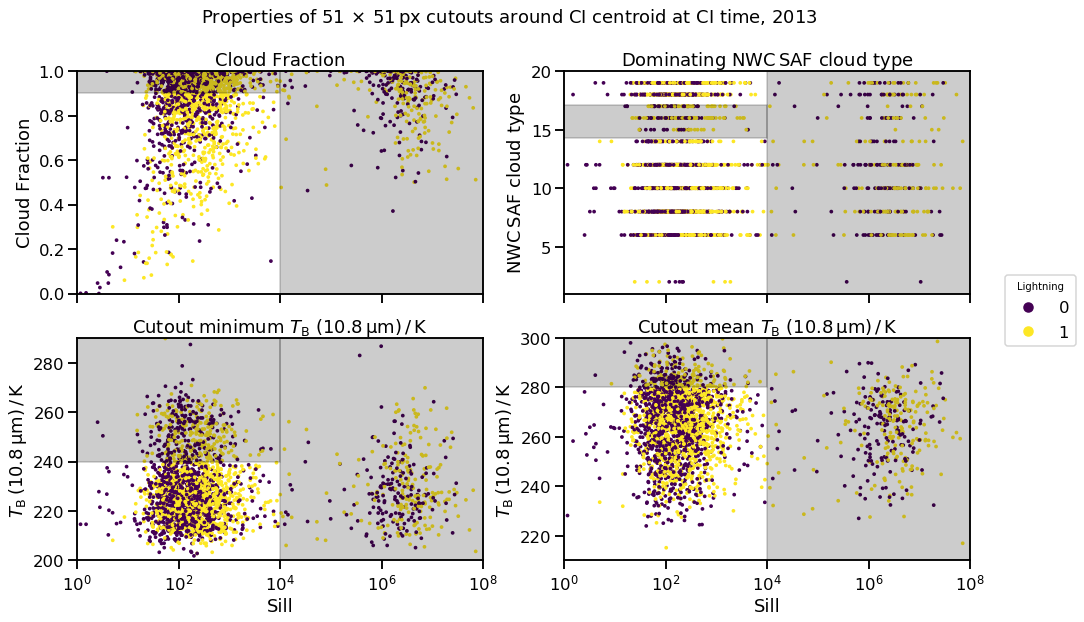

In [240]:
fig,ax = plt.subplots(2,2,figsize=(16,9),sharex=True)
axs = ax.ravel()
axs[0].scatter(sill_df.sill,sill_df.cl,s=5,c=sill_df.lightning)
axs[0].set_xscale("log")
axs[0].set_ylabel("Cloud Fraction")
axs[0].set_title("Cloud Fraction")
axs[0].axvspan(10000,1e8,color='k',alpha=0.2)
axs[0].axvspan(0,10000,0.9,1,color='k',alpha=0.2)
axs[0].set_xlim(1,1e8)
axs[0].set_ylim(0,1)

axs[1].scatter(sill_df.sill,sill_df.ct,s=5,c=sill_df.lightning)
axs[1].set_xscale("log")
axs[1].set_ylabel(r"NWC$\,$SAF cloud type")
axs[1].set_title(r"Dominating NWC$\,$SAF cloud type")
axs[1].axvspan(10000,1e8,color='k',alpha=0.2)
axs[1].axvspan(0,10000,1-((20-14)/20),1-((20-17)/20),color='k',alpha=0.2)
axs[1].set_xlim(1,1e8)
axs[1].set_ylim(1,20)

axs[2].scatter(sill_df.sill,sill_df.ir108_min,s=5,c=sill_df.lightning)
axs[2].set_xscale("log")
axs[2].set_title(r"Cutout minimum $T_\mathrm{B}$ (10.8$\,$µm)$\,/\,$K")
axs[2].set_ylabel(r"$T_\mathrm{B}\,$(10.8$\,$µm)$\,/\,$K")
axs[2].axvspan(10000,1e8,color='k',alpha=0.2)
axs[2].axvspan(0,10000,1-((290-240)/(290-200)),1,color='k',alpha=0.2)
axs[2].set_xlim(1,1e8)
axs[2].set_ylim(200,290)

p = axs[3].scatter(sill_df.sill,sill_df.ir108_mean,s=5,c=sill_df.lightning)
axs[3].set_xscale("log")
axs[3].set_title(r"Cutout mean $T_\mathrm{B}$ (10.8$\,$µm)$\,/\,$K")
axs[3].set_ylabel(r"$T_\mathrm{B}\,$(10.8$\,$µm)$\,/\,$K")
axs[3].axvspan(10000,1e8,color='k',alpha=0.2)
axs[3].axvspan(0,10000,1-((300-280)/(300-210)),1,color='k',alpha=0.2)
axs[3].set_xlim(1,1e8)
axs[3].set_ylim(210,300)

legend1 = fig.legend(*p.legend_elements(),
                    loc="center right", title="Lightning")

axs[2].set_xlabel(u"Sill")
axs[3].set_xlabel(u"Sill")
plt.suptitle(r"Properties of $51\,\times\,51\,$px cutouts around CI centroid at CI time, 2013",fontsize=18)
plt.savefig("/vols/satellite/home/lenk/notebooks/Vorträge/Doktorandenvortrag3/cutout_properties_thresh.pdf",bbox_inches='tight')

In [71]:
from matplotlib import colors as mcolors
import fixed_colourbar as fc

In [49]:
#Z = linkage(np.reshape(sill_df.sill.values, (len(sill_df.sill.values), 1)), 'ward')

In [286]:
obs = []

for i, r in sill_df.iterrows():
    obs.append([np.log10(r.sill),r.ct]) # ,r.ir108_min,r.sill,r.cl,r.len,

In [287]:
Z = linkage(np.array(obs), 'ward')

In [167]:
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=6.,  # font size for the x axis labels
)
plt.show()

KeyboardInterrupt: 

Es sieht so aus, als hätten wir zwei relativ gut getrennte Populationen, da es bei der Entfernung 2&thinsp;&middot;10<sup>8</sup> einen großen Sprung gibt. Als nächstes sehen wir uns mal die Entfernungen der letzten vier Verschmelzungen an.

In [80]:
Z[-4:,2]

array([6.05953164e+07, 6.89598521e+07, 1.57649214e+08, 2.14386080e+08])

In [81]:
Z_sub = Z[-5:,2]

In [82]:
for i,z in enumerate(Z_sub[1:]):
    try:
        print("{}".format(z - Z_sub[i] ))
    except:
        continue

955014.6097249538
8364535.6477493495
88689361.92979376
56736865.714194566


Die letzten drei Verschmelzung erzeugen einen relativ großen Sprung in der Entfernung. Hier wurden wahrschenlich zwei Gruppen verschmolzen, die nicht zusammengehören. Da das Dendrogramm mit allen Gruppen ziemlich unübersichtlich ist, lassen wir uns nur die letzten 12 Verschmelzungen anzeigen.

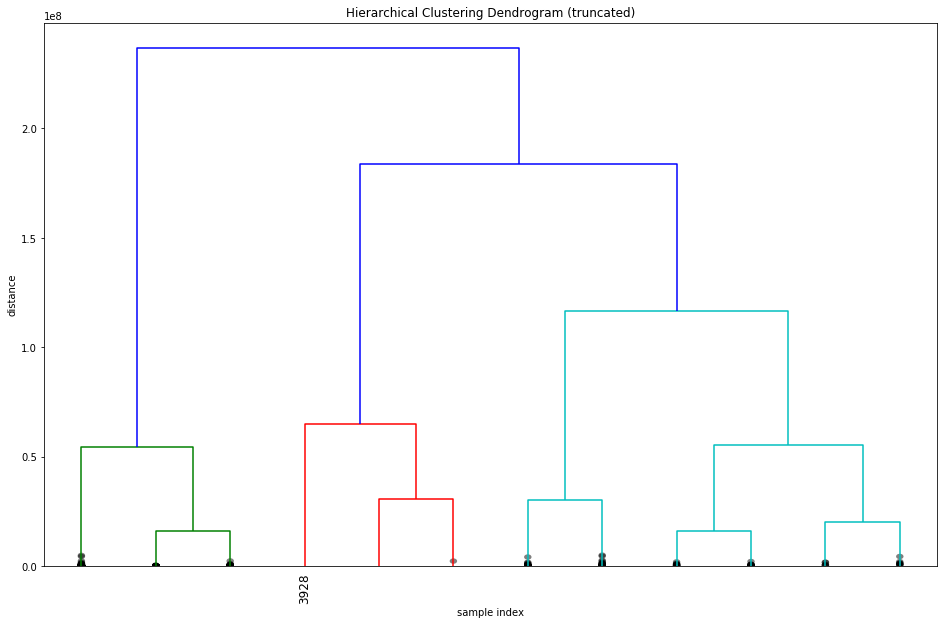

In [22]:
fig,ax = plt.subplots(1,1,figsize=(16,10))
plt.sca(ax)
plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=12,  # show only the last p merged clusters
    show_leaf_counts=False,  # otherwise numbers in brackets are counts
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.show()

Das ist bereits viel übersichtlicher, aber wir sehen nur eine Gruppennummer, da alle anderen bereits verschmolzen sind. Die Punkte zeigen uns die Entfernungen an, bei denen diese Verschmelzungen stattfanden. Es wäre allerdings vielleicht auch Interessant, wieviele Untergruppen die letzten 12 Verschmelzungen enthalten.

In [83]:
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

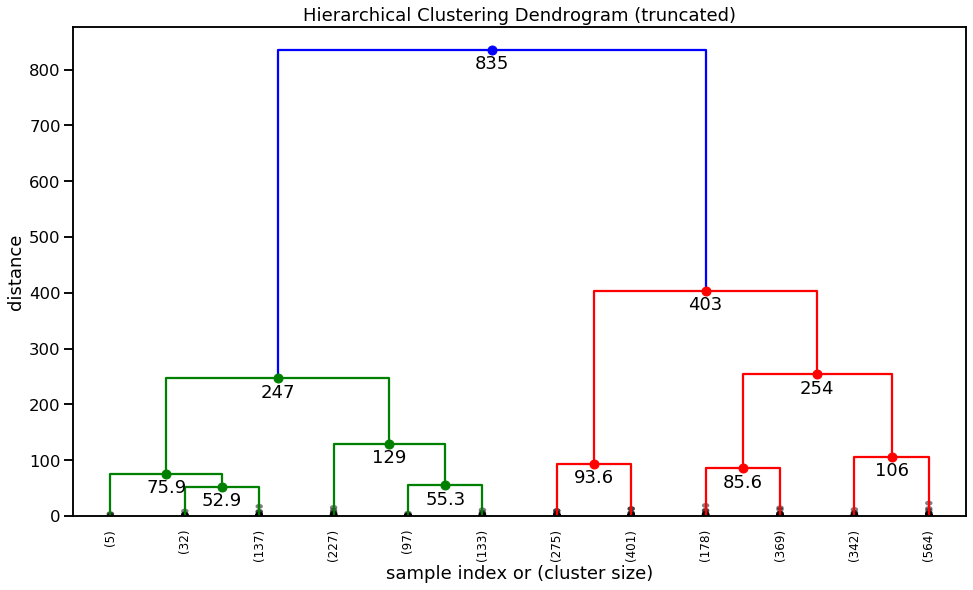

In [137]:
fig,ax = plt.subplots(1,1,figsize=(16,9))
plt.sca(ax)
fancy_dendrogram(
    Z,
    truncate_mode='lastp',
    p=12,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,  # useful in small plots so annotations don't overlap
)
plt.show()

Jetzt zeigt sich, dass es unterschiedlich große Gruppierungen gibt. Die grüne Gruppierung enthält eher wenige Objekte, insgesamt 4. Die rote Gruppierung enthält die meisten HACI-Objekte, die auch relativ ähnlich sind. Insbesondere die fünfte Gruppe von links enthält bereits {{"{:2.2f}%".format(100*(3825. / len(sill_df.sill.values)))}} aller HACI-Fälle der Jahres 2012, 2013 und 2014.
Deshalb ist es vielleicht eine gute Idee diese Gruppe als eigene Übergruppe zu behalten und den Schnittwert bei einer Entfernung von ca. 7&thinsp;&middot;&thinsp;10<sup>7</sup> anzsetzten. Damit sollten wir vier Gruppen erhalten.

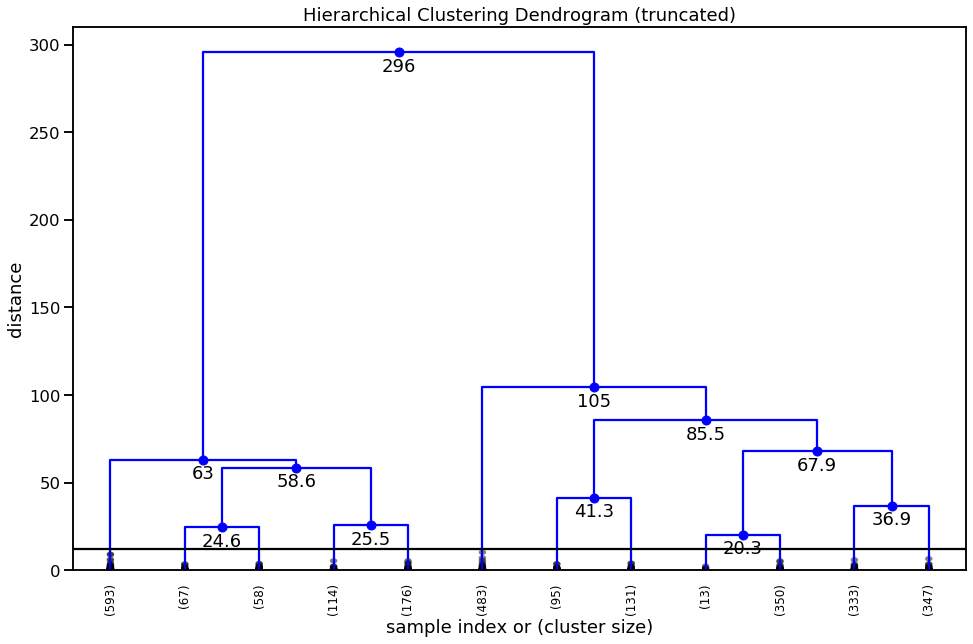

In [288]:
fig,ax = plt.subplots(1,1,figsize=(16,10))
plt.sca(ax)
fancy_dendrogram(
    Z,
    truncate_mode='lastp',
    p=12,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,
    max_d=12,  # plot a horizontal cut-off line
)
plt.show()

Als nächstes erzeugen wir einen Index für die Gruppenzuordnung.

In [289]:
from scipy.cluster.hierarchy import fcluster
max_d = 106
clusters = fcluster(Z, max_d, criterion='distance')
sill_df = sill_df.assign(cluster=clusters)

In [290]:
clusters

array([2, 1, 2, ..., 1, 1, 2], dtype=int32)

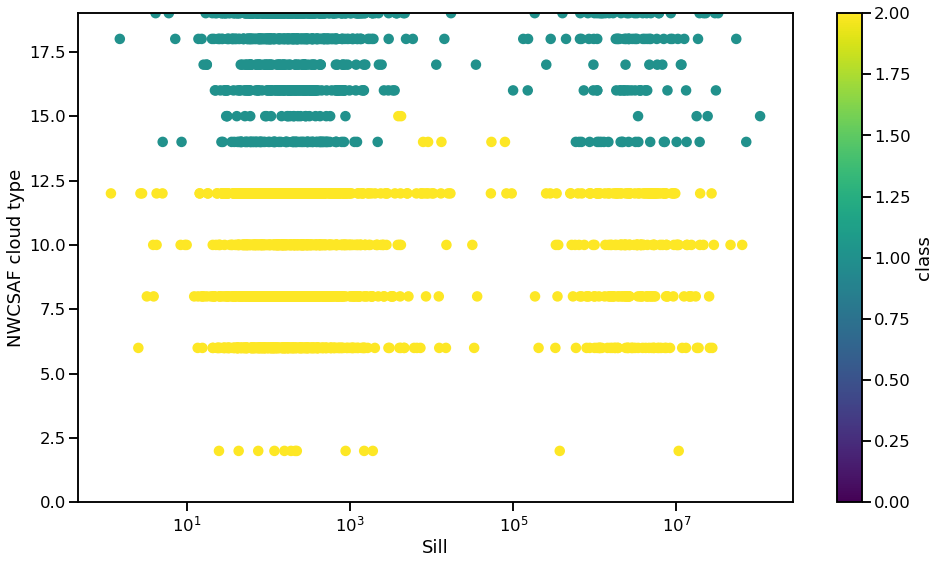

In [317]:
fig,ax = plt.subplots(figsize=(16, 9))
p = ax.scatter(sill_df.sill.values, 
               #sill_df.ir108_min.values,
               sill_df.ct.values, 
               c=clusters, vmin=0,vmax=2,cmap='viridis')  # plot points with cluster dependent colors
ax.set_xlabel("Sill")
ax.set_ylabel("NWCSAF cloud type")
ax.set_xscale("log")
ax.set_ylim(0,19)
plt.colorbar(p,label="class")

In [298]:
from sklearn.cluster import KMeans

In [299]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(obs)

In [300]:
kmeans

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)

In [301]:
kmeans.labels_

array([0, 1, 0, ..., 1, 1, 0], dtype=int32)

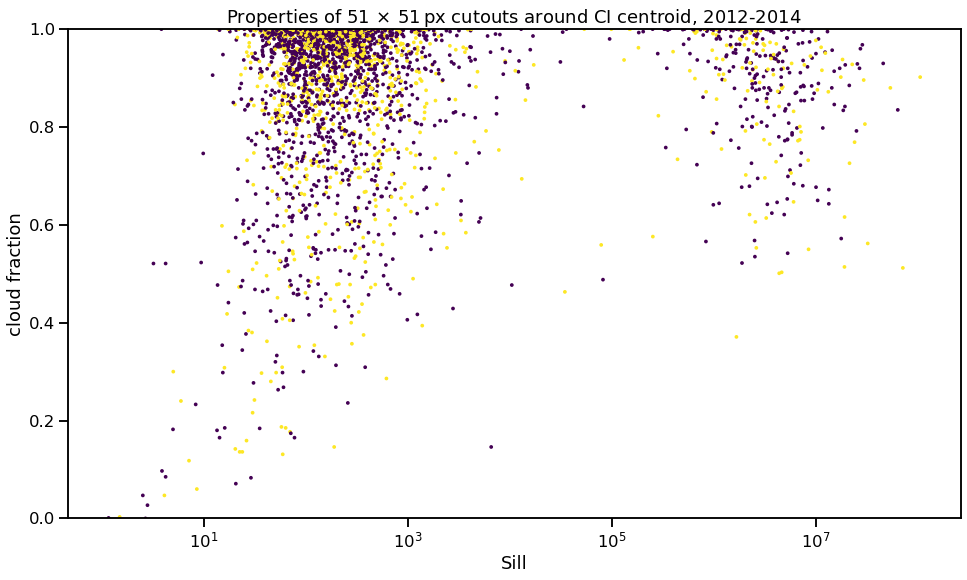

In [302]:
fig,ax = plt.subplots(1,1,figsize=(16,9))
ax.scatter(sill_df.sill,sill_df.cl,s=5,c=kmeans.labels_)#clusters)
ax.set_xscale("log")
#ax.set_yscale("log")
ax.set_xlabel(u"Sill")
ax.set_ylabel("cloud fraction")
ax.set_ylim(0,1)
ax.set_title(r"Properties of $51\,\times\,51\,$px cutouts around CI centroid, 2012-2014")
plt.savefig("/vols/satellite/home/lenk/notebooks/Vorträge/Doktorandenvortrag3/sill_cf.pdf",bbox_inches='tight')

In [307]:
sill_df[sill_df.cluster==1].describe()

sill           len           cl  cluster         year  \
count  1.008000e+03  1.008000e+03  1008.000000   1008.0  1008.000000   
mean   8.255175e+05  4.451024e+04     0.865749      1.0  2012.803571   
std    5.144555e+06  1.975195e+05     0.176348      0.0     0.784094   
min    1.495000e+00  2.569000e+00     0.003000      1.0  2012.000000   
25%    9.712925e+01  7.381500e+00     0.829750      1.0  2012.000000   
50%    2.150055e+02  1.254250e+01     0.933500      1.0  2013.000000   
75%    5.949588e+02  3.575875e+01     0.987000      1.0  2013.000000   
max    1.061304e+08  3.175236e+06     1.000000      1.0  2014.000000   

         ir108_min           ct  
count  1008.000000  1008.000000  
mean    225.331073    17.482143  
std      13.269230     1.644611  
min     201.839000    14.000000  
25%     214.891000    16.000000  
50%     222.702500    18.000000  
75%     233.422000    19.000000  
max     289.804000    19.000000

In [309]:
sill_df[sill_df.cluster==2].describe()

sill           len           cl  cluster         year  \
count  1.752000e+03  1.752000e+03  1752.000000   1752.0  1752.000000   
mean   6.677306e+05  4.239085e+04     0.872519      2.0  2012.791096   
std    3.070062e+06  1.596066e+05     0.163370      0.0     0.785920   
min    1.164000e+00  2.500000e+00     0.000000      2.0  2012.000000   
25%    9.233925e+01  7.569750e+00     0.823750      2.0  2012.000000   
50%    2.063765e+02  1.263950e+01     0.935000      2.0  2013.000000   
75%    6.267418e+02  3.426450e+01     0.987000      2.0  2013.000000   
max    6.401971e+07  2.851566e+06     1.000000      2.0  2014.000000   

         ir108_min           ct  
count  1752.000000  1752.000000  
mean    232.009614     9.220320  
std      13.575603     2.386062  
min     203.653000     2.000000  
25%     222.275000     8.000000  
50%     229.071000    10.000000  
75%     239.538000    12.000000  
max     287.374000    15.000000

In [103]:
sill_df[sill_df.cluster==3].describe()

sill           len         cl  cluster         year
count  3.500000e+01  3.500000e+01  35.000000     35.0    35.000000
mean   1.912646e+07  8.991750e+05   0.844743      3.0  2013.114286
std    6.149611e+06  3.913422e+05   0.132618      0.0     0.795998
min    1.133336e+07  1.905484e+05   0.514000      3.0  2012.000000
25%    1.349061e+07  6.802337e+05   0.795000      3.0  2012.500000
50%    1.839072e+07  8.337667e+05   0.896000      3.0  2013.000000
75%    2.350151e+07  1.078601e+06   0.933500      3.0  2014.000000
max    3.248089e+07  1.951205e+06   1.000000      3.0  2014.000000

In [279]:
test = sill_df[((sill_df.sill <= 10000) & (sill_df.sill>5)) & ((sill_df.ct < 15) | (sill_df.ct > 17)) & (sill_df.ir108_min < 240) & (sill_df.ir108_mean > 240) &(sill_df.ir108_mean< 280) & (sill_df.cl < 0.9)]

In [280]:
test.ir108_mean.describe()

count    558.000000
mean     262.462925
std        9.810929
min      240.598000
25%      255.276000
50%      263.230500
75%      270.410250
max      279.923000
Name: ir108_mean, dtype: float64

In [281]:
test

sill      len     cl             id  cluster  year  ir108_min    ct  \
4       32.249    6.626  0.663  20130810_1735        2  2013    219.509   6.0   
6       52.271    6.645  0.619   20131130_230        2  2013    220.964   8.0   
7      805.701   24.637  0.748  20130724_2315        2  2013    224.184  10.0   
15     629.737   23.340  0.828   20140612_865        2  2014    211.429  10.0   
18     164.269    5.139  0.884  20140630_9056        1  2014    228.695  19.0   
...        ...      ...    ...            ...      ...   ...        ...   ...   
2711    27.372    4.364  0.846  20130818_5040        2  2013    230.124   6.0   
2712  5858.917  292.033  0.792  20140501_4376        1  2014    223.555  18.0   
2737   120.965    4.816  0.824  20120730_8114        1  2012    227.820  19.0   
2755   457.939   18.281  0.827  20140422_3041        2  2014    239.781   8.0   
2759   105.274    8.122  0.486  20130916_9811        2  2013    228.113  10.0   

      ir108_mean  lightning  
4        277.127          0  
6        270.126          0  
7        259.644          1  
15       252.857          1  
18       277.860          1  
...          ...        ...  
2711     263.326          0  
2712     261.195          1  
2737     267.635          1  
2755     270.489          1  
2759     260.364          1  

[558 rows x 10 columns]

In [282]:
test.to_csv("/vols/satellite/home/lenk/data/HACI_bbox_data/selected_cases.csv",index=False)

In [245]:
import sys
sys.path.append("/vols/satellite/home/lenk/utils/tracking")
import object_tracking as ot

In [246]:
haci_cases = pd.read_csv("/vols/satellite/home/lenk/data/HACI_bbox_data/haci-2012-2014-bbox-filtered.csv")

In [247]:
haci_cases.head()

date   time     id  flags   t0   t1  l00  l01  c00  c01  ...  \
0  2012-01-02  22:10   8884      0  266  273  156  163  493  504  ...   
1  2012-01-03  19:50   7107      0  238  263  705  730  417  505  ...   
2  2012-01-05  09:25   5365      0  113  241  586  696  469  622  ...   
3  2012-01-06  13:45   4134      0  165  173  358  365  260  263  ...   
4  2012-01-07  18:30  10033      0  222  236  675  679  442  447  ...   

   msg_eu_l00  msg_eu_c00  msg_eu_l01  msg_eu_c01  msg_eu_l0  msg_eu_c0  \
0         213         503         212         506        213        503   
1         128         478         124         505        131        462   
2         145         494         129         540        151        459   
3         182         433         181         434        184        433   
4         132         486         131         487        138        486   

   msg_eu_l1  msg_eu_c1  year  lightning  
0        211        511  2012          0  
1        122        526  2012          1  
2        129        552  2012          1  
3        180        437  2012          0  
4        131        501  2012          0  

[5 rows x 29 columns]

In [270]:
lightning = []

In [271]:
for i, case in tqdm.tqdm(sill_df.iterrows(),total = len(sill_df.index)):
    date = "{}-{}-{}".format(case.id[0:4],case.id[4:6],case.id[6:8])
    cid = int(case.id.split("_")[1])
    
    haci_case = haci_cases[(haci_cases.date==date) & (haci_cases.id==cid)]
    
    lightning.append(haci_case.lightning.iloc[0])


100%|██████████| 2760/2760 [00:06<00:00, 410.53it/s]


In [272]:
sill_df = sill_df.assign(lightning=lightning)

In [104]:
haci_cases = haci_cases[(haci_cases.year>=2012) & (haci_cases.year<=2014)]

In [259]:
from plotting_tools.bmaps import radolan_rx_map
from io_tools import radolan
r = radolan.Radolan()
from plotting_tools.colormaps import enhanced_colormap
emap = enhanced_colormap()

In [251]:
lcol = {0:'blue',1:'red'}
marker = {0:'o',1:'v'}

/vols/satellite/home/lenk/lib/tropy/plotting_tools/bmaps.py:224: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  resolution='i')
/vols/satellite/home/lenk/lib/tropy/plotting_tools/bmaps.py:231: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  linewidth=lwd)


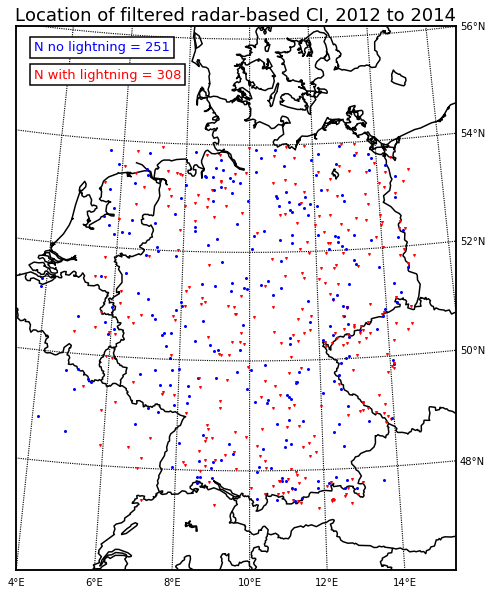

In [252]:
fig,ax,m = radolan_rx_map(linecolour='black',figsize=(10,10))
plt.sca(ax)

for i, case in test.iterrows():
    date = "{y}-{m}-{d}".format(y = case.id.split("_")[0][0:4],
                                m = case.id.split("_")[0][4:6],
                                d = case.id.split("_")[0][6:8])
    case_id = int(case.id.split("_")[1])   
    
    haci_case = haci_cases[(haci_cases.date == date) & (haci_cases.id == case_id)]
    
    l = haci_case.l00 + ((haci_case.l01 - haci_case.l00)//2)
    c = haci_case.c00 + ((haci_case.c01 - haci_case.c00)//2)
    x,y = m(r.lon[l,c], r.lat[l,c])
    ax.plot(x,y,color=lcol[case.lightning],marker=marker[case.lightning],markersize=2)

ax.text(0.04,0.95,"N no lightning = {}".format(len(test[test.lightning==0])),
        fontsize=13, va='bottom', color='blue',
        transform=ax.transAxes,bbox=dict(boxstyle="square",ec='k',fc='w')
     )
ax.text(0.04,0.90,r"N with lightning = {}".format(len(test[test.lightning==1])), 
        fontsize=13, va='bottom',
        color='red',transform=ax.transAxes,bbox=dict(boxstyle="square",ec='k',fc='w')
     )    
ax.set_title("Location of filtered radar-based CI, 2012 to 2014")
plt.savefig("/vols/satellite/home/lenk/notebooks/Vorträge/Doktorandenvortrag3/HACI_Fallkarte_2012-2014_gefiltert.pdf",bbox_inches='tight')

In [253]:
case = test.iloc[2]

In [254]:
case

sill                805.701
len                  24.637
cl                    0.748
id            20130724_2315
cluster                   2
year                   2013
ir108_min           224.184
ct                       10
ir108_mean          259.644
lightning                 1
Name: 7, dtype: object

In [255]:
case_data = xr.open_dataset("/vols/satellite/home/lenk/data/HACI_track_data/track_{}.nc".format(case.id))

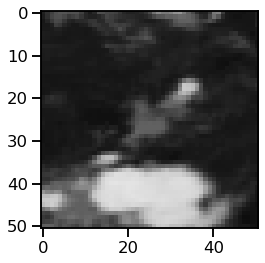

In [256]:
plt.imshow(case_data.ir108.data[6],cmap='gray_r',vmin=210,vmax=300)

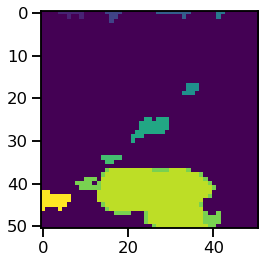

In [257]:
plt.imshow(ot.segment_local_threshold(case_data.ir108.data[7]))

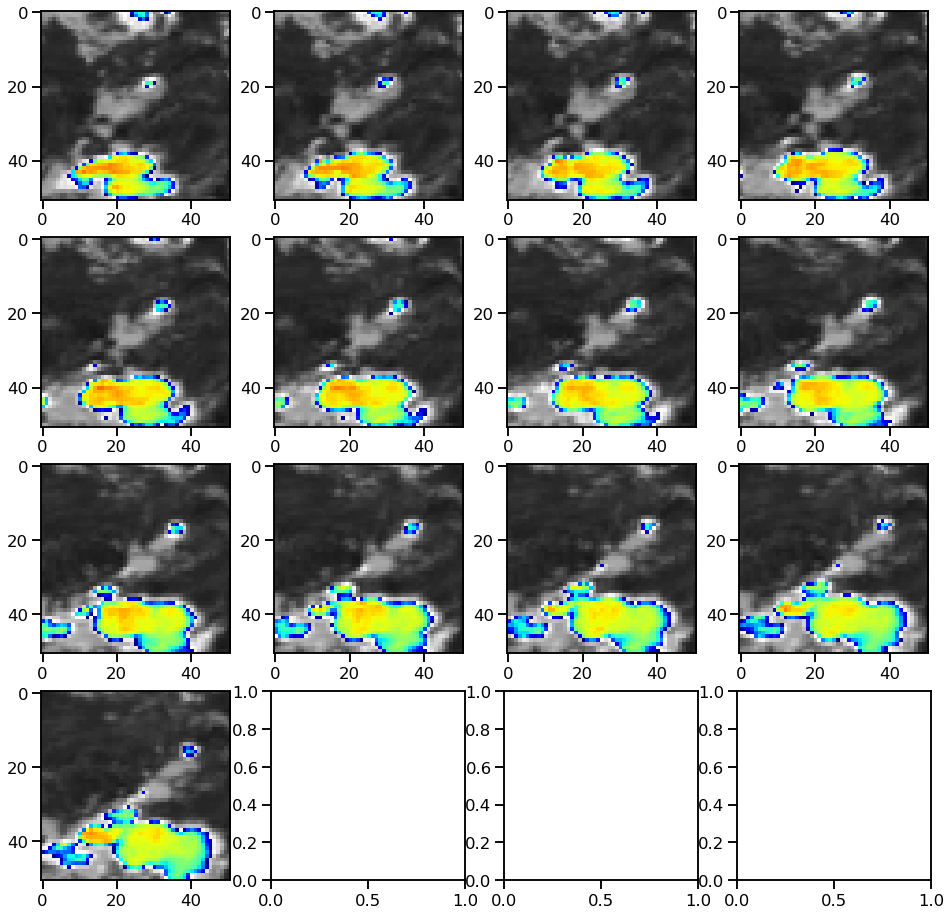

In [260]:
fig,ax = plt.subplots(4,4,figsize=(16,16))
axs = ax.ravel()

for i,f in enumerate(case_data.ir108.data):
    axs[i].imshow(f,vmin=210,vmax=300,cmap=emap)

In [ ]:
20130724

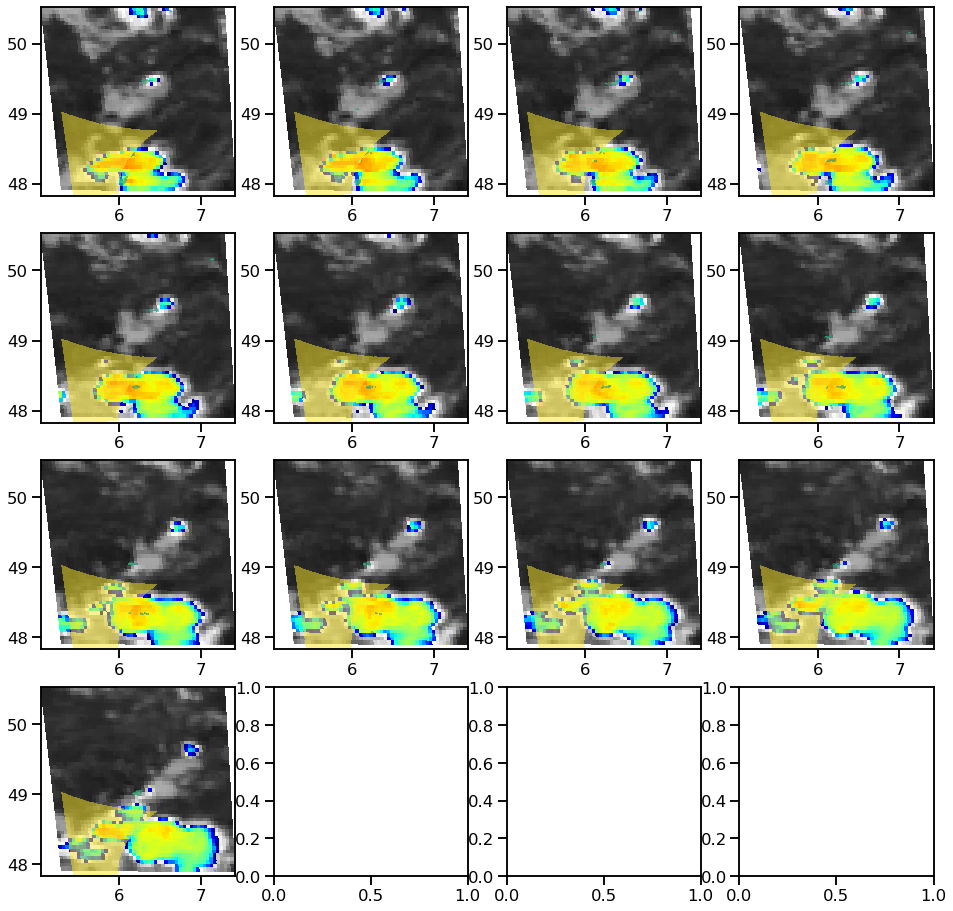

In [266]:
fig,ax = plt.subplots(4,4,figsize=(16,16))
axs = ax.ravel()

for i,f in enumerate(case_data.rx.data):
    axs[i].pcolormesh(case_data.slon,case_data.slat,case_data.ir108.data[i],vmin=210,vmax=300,cmap=emap)
    axs[i].contourf(case_data.rlon, case_data.rlat,np.ma.masked_less(f,35),vmin=5,vmax=70,alpha=0.5)

In [166]:
from importlib import reload

In [169]:
reload(ot)

<module 'object_tracking' from '/vols/satellite/home/lenk/utils/tracking/object_tracking.py'>

In [179]:
fl = [ot.segment_local_threshold(ir) for ir in case_data.ir108.data]

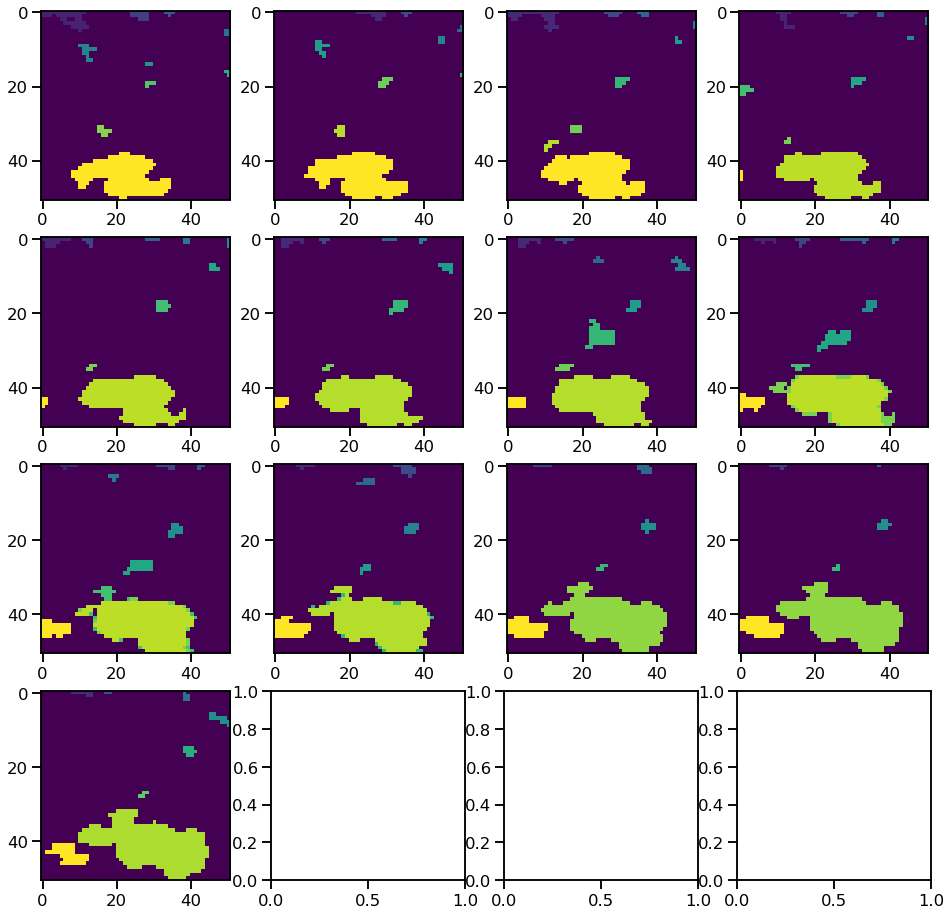

In [180]:
fig,ax = plt.subplots(4,4,figsize=(16,16))
axs = ax.ravel()

for i,f in enumerate(fl):
    axs[i].imshow(f)

In [183]:
case_track = ot.get_track_from_labeled_field(fl)

In [184]:
case_track

['11_0004', '6_0006', '8_0006', '7_0006', '10_0004', '12_0006', '9_0005']

In [185]:
obj = ot.get_wanted_object_field(fl,case_track)

In [186]:
len(obj)

7

In [187]:
obj

{11: array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint16),
 6: array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint16),
 8: array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint16),
 7: array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint16),
 10: array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [

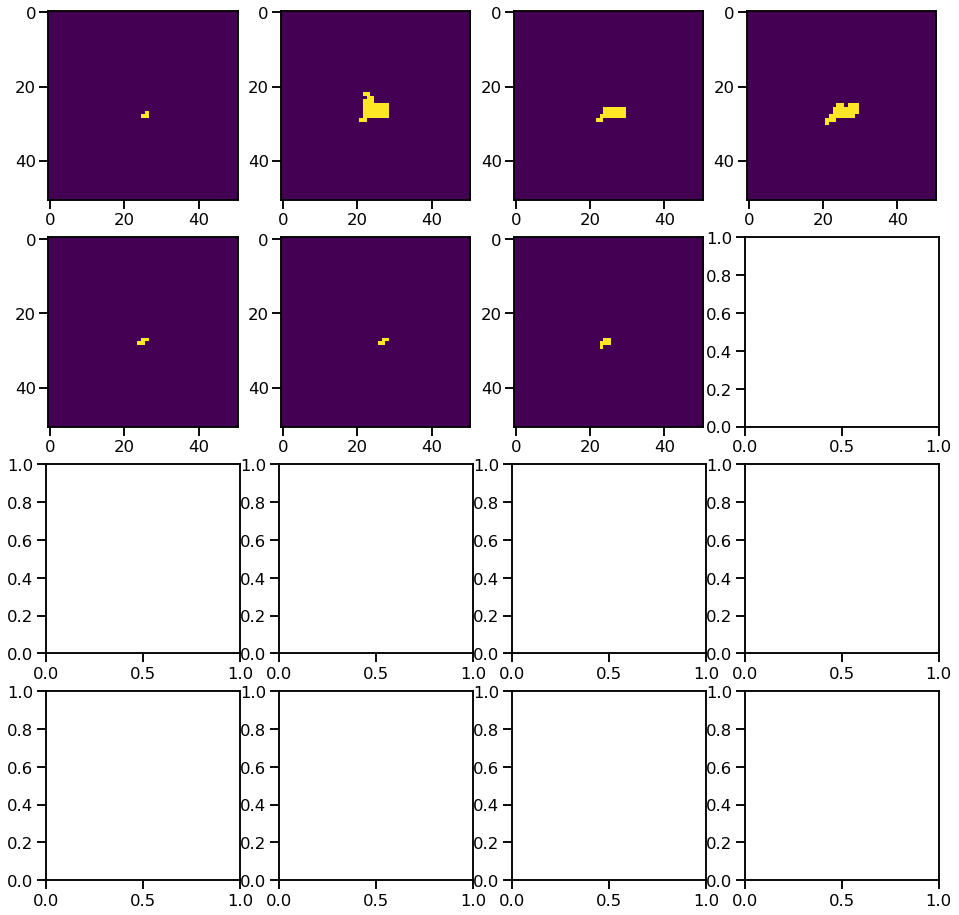

In [188]:
fig,ax = plt.subplots(4,4,figsize=(16,16))
axs = ax.ravel()

for i,o in enumerate(obj.keys()):
    axs[i].imshow(obj[o])

In [379]:
ir108 =  []
ir108_t5 =  []
wv062_ir108 = []
wv062_ir108_t5 = []
wv062_wv073 = []
ir087_ir108 = []
ir087_ir108_t5 = []
tri_t5 = []
times = []
tracks = []

for ci, case in tqdm.tqdm(test.iterrows(),total = len(test.id)):
    case_data = xr.open_dataset("/vols/satellite/home/lenk/data/HACI_track_data/track_{}.nc".format(case.id))
    fl = [ot.segment_local_threshold(ir) for ir in case_data.ir108.data]
    
    try:
        case_track = ot.get_track_from_labeled_field(fl)
        obj = ot.get_wanted_object_field(fl,case_track)

        track_val = {'ir108' : [],
                     'ir108_t5' : [],
                     'wv062_ir108' : [],
                     'wv062_ir108_t5' : [],
                     'wv062_wv073' : [],
                     'ir087_ir108' : [],
                     'ir087_ir108_t5' : [],
                     'tri' : [],
                     'tri_t5' : []}

        for k in obj.keys():
            wv062v = case_data.wv062.data[k][np.where(obj[k]==1)]
            wv073v = case_data.wv073.data[k][np.where(obj[k]==1)]
            ir087v = case_data.ir087.data[k][np.where(obj[k]==1)]
            ir108v = case_data.ir108.data[k][np.where(obj[k]==1)]
            ir120v = case_data.ir120.data[k][np.where(obj[k]==1)]

            ir108v = sorted(ir108v)

            # take coldest 10 %
            n_px = int(np.rint(len(ir108v)))

            if n_px < len(ir108v):
                wv062_mean = np.mean(wv062v)
                wv073_mean = np.mean(wv073v)
                ir087_mean = np.mean(ir087v)
                ir108_mean = np.mean(ir108v)
                ir120_mean = np.mean(ir120v)

                if len(track_val['ir108'])==0:
                    track_val['ir108_t5'].append(np.nan)
                else:
                    track_val['ir108_t5'].append(ir108_mean - track_val['ir108'][-1])

                if len(track_val['wv062_ir108_t5'])==0:
                    track_val['wv062_ir108_t5'].append(np.nan)
                else:
                    track_val['wv062_ir108_t5'].append((wv062_mean - ir108_mean) - track_val['wv062_ir108'][-1])

                if len(track_val['ir087_ir108_t5'])==0:
                    track_val['ir087_ir108_t5'].append(np.nan)
                else:
                    track_val['ir087_ir108_t5'].append((ir087_mean - ir108_mean) - track_val['ir087_ir108'][-1]) 

                if len(track_val['tri_t5'])==0:
                    track_val['tri_t5'].append(np.nan)
                else:
                    track_val['tri_t5'].append((ir087_mean - ir108_mean)- (ir108_mean - ir120_mean) - track_val['tri'][-1])                                  

                track_val['ir108'].append(ir108_mean)
                track_val['wv062_ir108'].append(wv062_mean - ir108_mean)
                track_val['wv062_wv073'].append(wv062_mean - wv073_mean)
                track_val['ir087_ir108'].append(ir087_mean - ir108_mean)
                track_val['tri'].append((ir087_mean - ir108_mean)- (ir108_mean - ir120_mean))               

            else:
                # location of those pixels
                px_loc = []

                for i in range(n_px):
                    px_loc.append(np.where(np.ma.masked_where(obj[k]==0,case_data.ir108.data[k]) == ir108v[i]))

                px_loc0 = np.array([p[0][0] for p in px_loc])
                px_loc1 = np.array([p[1][0] for p in px_loc])

                px_loc = (px_loc0,px_loc1)

                wv062_mean = np.mean(case_data.wv062.data[k][px_loc])
                wv073_mean = np.mean(case_data.wv062.data[k][px_loc])
                ir087_mean = np.mean(case_data.ir087.data[k][px_loc])
                ir108_mean = np.mean(case_data.ir108.data[k][px_loc])
                ir120_mean = np.mean(case_data.ir120.data[k][px_loc])   

                if len(track_val['ir108'])==0:
                    track_val['ir108_t5'].append(np.nan)
                else:
                    track_val['ir108_t5'].append(ir108_mean - track_val['ir108'][-1])

                if len(track_val['wv062_ir108_t5'])==0:
                    track_val['wv062_ir108_t5'].append(np.nan)
                else:
                    track_val['wv062_ir108_t5'].append((wv062_mean - ir108_mean) - track_val['wv062_ir108'][-1])

                if len(track_val['ir087_ir108_t5'])==0:
                    track_val['ir087_ir108_t5'].append(np.nan)
                else:
                    track_val['ir087_ir108_t5'].append((ir087_mean - ir108_mean) - track_val['ir087_ir108'][-1]) 

                if len(track_val['tri_t5'])==0:
                    track_val['tri_t5'].append(np.nan)
                else:
                    track_val['tri_t5'].append((ir087_mean - ir108_mean)- (ir108_mean - ir120_mean) - track_val['tri'][-1])                                  

                track_val['ir108'].append(ir108_mean)
                track_val['wv062_ir108'].append(wv062_mean - ir108_mean)
                track_val['wv062_wv073'].append(wv062_mean - wv073_mean)
                track_val['ir087_ir108'].append(ir087_mean - ir108_mean)
                track_val['tri'].append((ir087_mean - ir108_mean)- (ir108_mean - ir120_mean))                 

                ir108.extend(track_val['ir108'])
                ir108_t5.extend(track_val['ir108_t5'])
                wv062_ir108.extend(track_val['wv062_ir108'])
                wv062_ir108_t5.extend(track_val['wv062_ir108_t5'])
                wv062_wv073.extend(track_val['wv062_wv073'])
                ir087_ir108.extend(track_val['ir087_ir108'])
                ir087_ir108_t5.extend(track_val['ir087_ir108_t5'])
                tri_t5.extend(track_val['tri_t5'])
                times.extend([k*5 - 30]*len(obj.keys()))
                tracks.extend([case.id]*len(obj.keys())) 
                #lightnings.extend([case.lightning] * len(obj.keys()))
    except:
         continue


 28%|██▊       | 155/558 [04:34<12:06,  1.80s/it]


 55%|█████▌    | 309/558 [09:14<08:05,  1.95s/it]


 83%|████████▎ | 463/558 [13:22<00:52,  1.80it/s]


100%|██████████| 558/558 [15:39<00:00,  1.68s/it]


In [381]:
obj_df = pd.DataFrame({'ir108': ir108,
                       'ir108_t5':  ir108_t5,
                       'wv062_ir108': wv062_ir108,
                       'wv062_ir108_t5': wv062_ir108_t5,
                       'wv062_wv073': wv062_wv073,
                       'ir087_ir108': ir087_ir108,
                       'ir087_ir108_t5': ir087_ir108_t5,
                       'tri_t5': tri_t5,
                       'times':times,
                       'tracks': tracks})

ValueError: arrays must all be same length

In [383]:
len(tracks)

43054

In [ ]:
obj_df.to_csv("/vols/satellite/home/lenk/proj/2019-01_trackingstudie/data/object_data.csv",index=False)


 28%|██▊       | 155/559 [00:57<02:09,  3.11it/s]


 55%|█████▌    | 309/559 [01:55<01:33,  2.69it/s]


 83%|████████▎ | 463/559 [02:52<00:33,  2.90it/s]


100%|██████████| 559/559 [03:29<00:00,  2.67it/s]


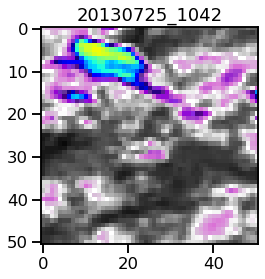

In [86]:
lc = len(test.cluster.values)
d = divisors(lc)

ncol = sorted(list(d))[len(list(d))//2]
nrow = lc // ncol

for i, tr in tqdm.tqdm(test.iterrows(),total=lc):
    try:
        with xr.open_dataset("/vols/satellite/home/lenk/data/HACI_track_data/track_{}.nc".format(tr.loc['id'])) as file:
            ir108 = file.ir108.data[6]

        fig,ax = plt.subplots(1,1,figsize=(4,4))    
        ax.imshow(ir108,vmin=210,vmax=300,cmap=emap)
        ax.set_title(tr.loc['id'])
        plt.savefig("/vols/satellite/home/lenk/proj/2019-01_trackingstudie/pics/test_class/{}.png".format(tr.loc['id']))
        plt.close()
    except:
        continue

Gruppe zwei ist diejenige mit den meisten Fällen und den eher niedrigen Sill-Werten, also die Fälle, wo die räumliche Ähnlichkeit im Ausschnitt des IR&thinsp;10,8&thinsp;µm-Kanals zum CI-Zeitpunkt eher klein ist. Das sind wahrscheinlich die Fälle wo der Ausschnitt mit vielen hohen Wolken ausgefüllt ist. Gruppe 1 ist die kleinste Gruppe und diejenige mit den relativ hohen Sill-Werten, also die Gruppe, wo die räumliche Ähnlichkeit im Ausschnitt eher groß ist. Gruppe drei liegt dazwischen.

Die Interessante Gruppe ist Gruppe zwei. Aber auch hier sind die Sill-Werte und deren Streuung mit im Mittel {{"{:2.0f}".format(sill_df[sill_df.cluster==2].describe().loc['mean'].sill)}}&thinsp;&pm;&thinsp;{{"{:2.0f}".format(sill_df[sill_df.cluster==2].describe().loc['std'].sill)}} recht hoch. Deshalb lohnt es sich vielleicht sich diese Gruppe nochmal genauer anzusehen.

In [104]:
sill_df[sill_df.cluster==2]

sill        len     cl              id  cluster  year
2         90.563      9.930  0.864   20130422_1206        2  2013
5         59.426      7.436  0.131   20140610_2672        2  2014
6        574.465     37.823  0.999   20130427_1831        2  2013
7         47.953      7.613  1.000   20120803_1443        2  2012
9         32.249      6.626  0.663   20130810_1735        2  2013
...          ...        ...    ...             ...      ...   ...
4343     457.939     18.281  0.827   20140422_3041        2  2014
4344      86.208      7.862  0.930   20120803_5535        2  2012
4345  400408.317  20898.431  0.954   20140611_4835        2  2014
4346     244.793     12.275  0.942  20140509_12624        2  2014
4349     105.274      8.122  0.486   20130916_9811        2  2013

[2630 rows x 6 columns]

In [25]:
from plotting_tools.colormaps import enhanced_colormap2
emap = enhanced_colormap2()

In [24]:
def divisors(n):
    divs = {1,n}
    for i in range(2,int(np.sqrt(n))+1):
        if n%i == 0:
            divs.update((i,n//i))
    return divs

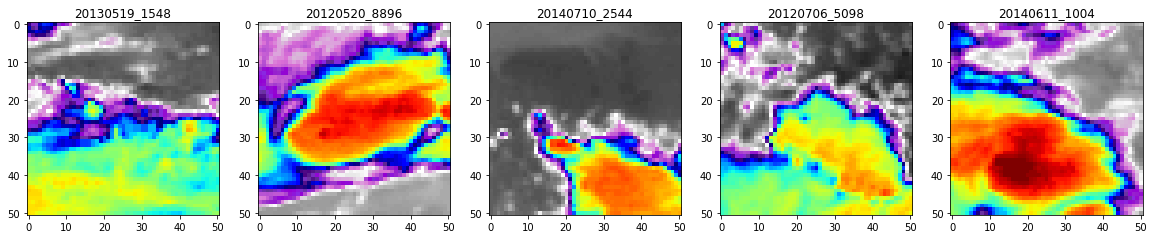

In [62]:
d = divisors(len(sill_df[sill_df.cluster==1].cluster.values))

nrow = sorted(list(d))[len(list(d))//2]
ncol = len(sill_df[sill_df.cluster==1].cluster.values) // nrow

fig,ax = plt.subplots(ncol,nrow,figsize=(nrow*4,ncol*4))
axs = ax.ravel()

j = 0
for i, tr in sill_df[sill_df.cluster==1].iterrows():
    
    with xr.open_dataset("/vols/satellite/home/lenk/data/HACI_track_data/track_{}.nc".format(tr.loc['id'])) as file:
        ir108 = file.ir108.data[6]
        
    axs[j].imshow(ir108,vmin=210,vmax=300,cmap=emap)
    axs[j].set_title(tr.id)
    
    j += 1

In der ersten Gruppe sind hauptsächlich die Objekte, wo es bereits mature Gewitter im Ausschnitt gibt und sich inderen Nähe ein neues entwickelt, aber Objekt 20130620_645 ist eigentlich ein relativ schön isoliertes.

100%|██████████| 72/72 [00:18<00:00,  3.89it/s]


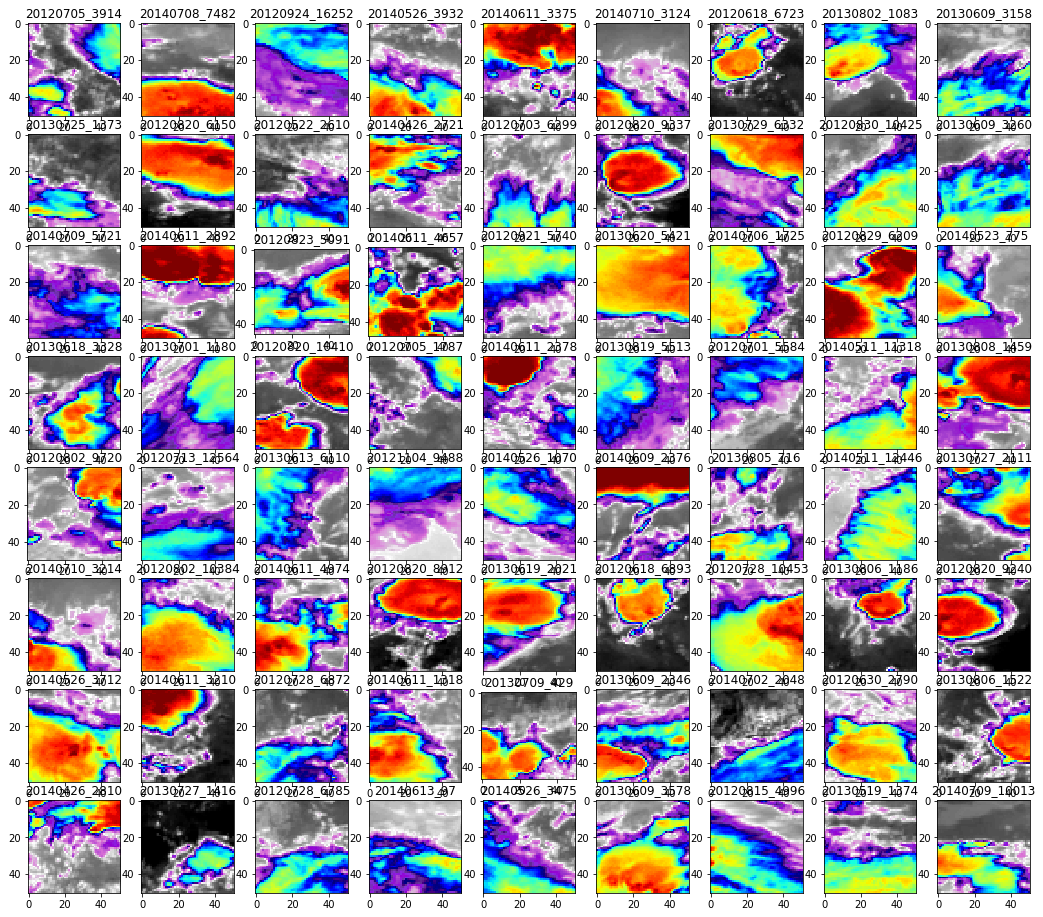

In [68]:
lc = len(sill_df[sill_df.cluster==3].cluster.values)
d = divisors(lc)

nrow = sorted(list(d))[len(list(d))//2]
ncol = lc // nrow

fig,ax = plt.subplots(ncol,nrow,figsize=(nrow*2,ncol*2))
axs = ax.ravel()

j = 0
for i, tr in tqdm.tqdm(sill_df[sill_df.cluster==3].iterrows(),total=lc):
    
    with xr.open_dataset("/vols/satellite/home/lenk/data/HACI_track_data/track_{}.nc".format(tr.loc['id'])) as file:
        ir108 = file.ir108.data[6]
        
    axs[j].imshow(ir108,vmin=210,vmax=300,cmap=emap)
    axs[j].set_title(tr.id)
    
    j += 1

Die Fälle in Gruppe 3 sind auch dmoniert durch bereits bestehende mature Konvektion oder stratiforme Niederschlagsbereiche. Das sind fast ausschließlich auch keine isolierten konvektiven Fälle.

In [313]:
lc = len(sill_df[sill_df.cluster==2].cluster.values)
d = divisors(lc)

ncol = sorted(list(d))[len(list(d))//2]
nrow = lc // ncol

#fig,ax = plt.subplots(ncol,nrow,figsize=(nrow*2,ncol*2))
#axs = ax.ravel()

#j = 0
for i, tr in tqdm.tqdm(sill_df[sill_df.cluster==2].iterrows(),total=lc):
    
    with xr.open_dataset("/vols/satellite/home/lenk/data/HACI_track_data/track_{}.nc".format(tr.loc['id'])) as file:
        ir108 = file.ir108.data[6]
        
    fig,ax = plt.subplots(1,1,figsize=(4,4))    
    ax.imshow(ir108,vmin=210,vmax=300,cmap=emap)
    ax.set_title(tr.loc['id'])
    plt.savefig("/vols/satellite/home/lenk/proj/2019-01_trackingstudie/pics/class2/{}_var_{}.png".format(tr.loc['id'],
                                                                                                         int(np.rint(tr.loc['sill']))))
    plt.close()
    #j += 1

100%|██████████| 1752/1752 [07:11<00:00,  4.06it/s]


In [314]:
lc = len(sill_df[sill_df.cluster==1].cluster.values)
d = divisors(lc)

ncol = sorted(list(d))[len(list(d))//2]
nrow = lc // ncol

#fig,ax = plt.subplots(ncol,nrow,figsize=(nrow*2,ncol*2))
#axs = ax.ravel()

#j = 0
for i, tr in tqdm.tqdm(sill_df[sill_df.cluster==2].iterrows(),total=lc):
    
    with xr.open_dataset("/vols/satellite/home/lenk/data/HACI_track_data/track_{}.nc".format(tr.loc['id'])) as file:
        ir108 = file.ir108.data[6]
        
    fig,ax = plt.subplots(1,1,figsize=(4,4))    
    ax.imshow(ir108,vmin=210,vmax=300,cmap=emap)
    ax.set_title(tr.loc['id'])
    plt.savefig("/vols/satellite/home/lenk/proj/2019-01_trackingstudie/pics/class1/{}_var_{}.png".format(tr.loc['id'],
                                                                                                         int(np.rint(tr.loc['sill']))))
    plt.close()
    #j += 1

1752it [05:38,  5.17it/s]                          


In [26]:
lc = len(sill_df[sill_df.sill<=10000].sill.values)
d = divisors(lc)

ncol = sorted(list(d))[len(list(d))//2]
nrow = lc // ncol

#fig,ax = plt.subplots(ncol,nrow,figsize=(nrow*2,ncol*2))
#axs = ax.ravel()

#j = 0
for i, tr in tqdm.tqdm(sill_df[sill_df.sill<=10000].iterrows(),total=lc):
    
    with xr.open_dataset("/vols/satellite/home/lenk/data/HACI_track_data/track_{}.nc".format(tr.loc['id'])) as file:
        ir108 = file.ir108.data[6]
        
    fig,ax = plt.subplots(1,1,figsize=(4,4))    
    ax.imshow(ir108,vmin=210,vmax=300,cmap=emap)
    ax.set_title(tr.loc['id'])
    plt.savefig("/vols/satellite/home/lenk/proj/2019-01_trackingstudie/pics/sill_low/{}_var_{}.png".format(tr.loc['id'],
                                                                                                         int(np.rint(tr.loc['sill']))))
    plt.close()
    #j += 1

100%|██████████| 2385/2385 [14:56<00:00,  2.66it/s]


In [28]:
lc = len(sill_df[sill_df.sill>10000].sill.values)
d = divisors(lc)

ncol = sorted(list(d))[len(list(d))//2]
nrow = lc // ncol

#fig,ax = plt.subplots(ncol,nrow,figsize=(nrow*2,ncol*2))
#axs = ax.ravel()

#j = 0
for i, tr in tqdm.tqdm(sill_df[sill_df.sill>10000].iterrows(),total=lc):
    
    with xr.open_dataset("/vols/satellite/home/lenk/data/HACI_track_data/track_{}.nc".format(tr.loc['id'])) as file:
        ir108 = file.ir108.data[6]
        
    fig,ax = plt.subplots(1,1,figsize=(4,4))    
    ax.imshow(ir108,vmin=210,vmax=300,cmap=emap)
    ax.set_title(tr.loc['id'])
    plt.savefig("/vols/satellite/home/lenk/proj/2019-01_trackingstudie/pics/sill_high/{}_var_{}.png".format(tr.loc['id'],
                                                                                                         int(np.rint(tr.loc['sill']))))
    plt.close()
    #j += 1


 41%|████▏     | 155/375 [01:09<01:52,  1.95it/s]


 82%|████████▏ | 309/375 [02:18<00:31,  2.12it/s]


100%|██████████| 375/375 [02:59<00:00,  2.09it/s]


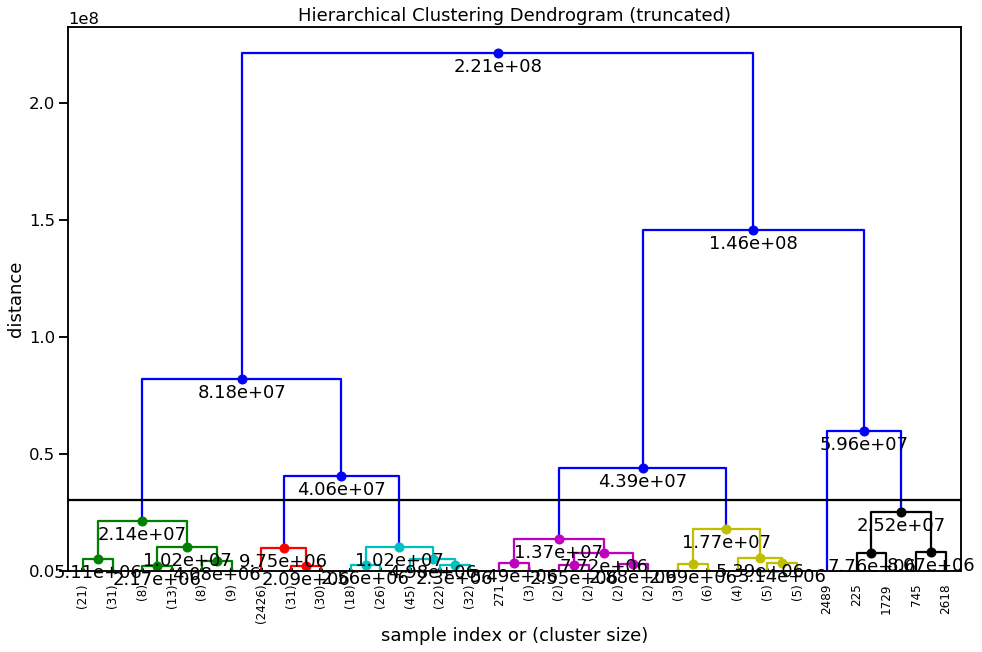

In [105]:
fig,ax = plt.subplots(1,1,figsize=(16,10))
plt.sca(ax)
fancy_dendrogram(
    Z,
    truncate_mode='lastp',
    p=30,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,
    max_d=3e7,  # plot a horizontal cut-off line
)
plt.show()

In [106]:
obs_cl2 = []

for i, r in sill_df[sill_df.cluster==2].iterrows():
    obs_cl2.append([r.sill,r.cl,r.len])

In [107]:
Z_cl2 = linkage(np.array(obs_cl2), 'ward')

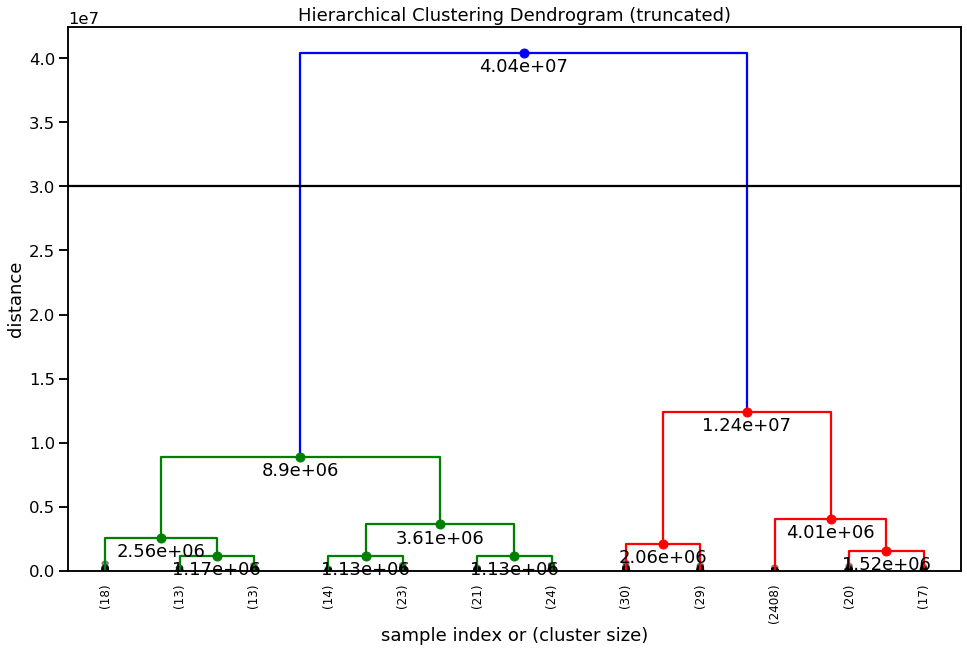

In [108]:
fig,ax = plt.subplots(1,1,figsize=(16,10))
plt.sca(ax)
fancy_dendrogram(
    Z_cl2,
    truncate_mode='lastp',
    p=12,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,
    max_d=3e7,  # plot a horizontal cut-off line
)
plt.show()

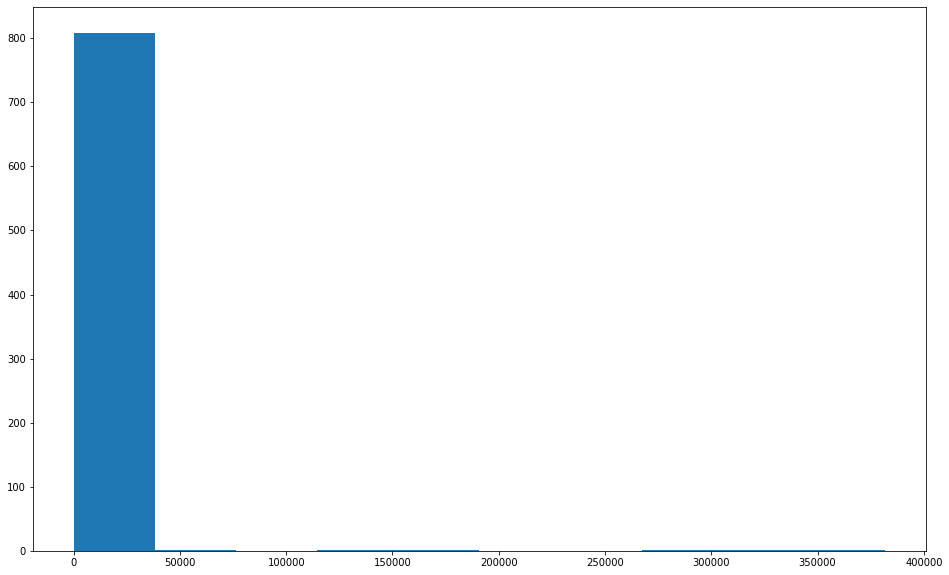

In [210]:
fig,ax = plt.subplots(1,1,figsize=(16,10))
H,b,p = ax.hist(sill_df[sill_df.cluster==2].sill.values)

In [73]:
cl2_df = sill_df[sill_df.cluster==2]

In [74]:
max_d = 3e7
clusters_cl2 = fcluster(Z_cl2, max_d, criterion='distance')
cl2_df = cl2_df.assign(cluster2=clusters_cl2)

In [75]:
cl2_df[cl2_df.cluster2==1].describe()

sill            len           cl  cluster         year  \
count  2.504000e+03    2504.000000  2504.000000   2504.0  2504.000000   
mean   3.439112e+04    6300.518677     0.870444      2.0  2012.791933   
std    1.860477e+05   36334.853080     0.171798      0.0     0.785556   
min    1.164000e+00       2.500000     0.000000      2.0  2012.000000   
25%    8.673200e+01       7.156750     0.827000      2.0  2012.000000   
50%    1.814185e+02      11.341500     0.938000      2.0  2013.000000   
75%    4.031972e+02      23.655750     0.988000      2.0  2013.000000   
max    1.601399e+06  524172.083000     1.000000      2.0  2014.000000   

       cluster2  
count    2504.0  
mean        1.0  
std         0.0  
min         1.0  
25%         1.0  
50%         1.0  
75%         1.0  
max         1.0

In [76]:
cl2_df[cl2_df.cluster2==2].describe()

sill            len          cl  cluster         year  cluster2
count  1.790000e+02     179.000000  179.000000    179.0   179.000000     179.0
mean   3.341061e+06  241935.150721    0.873832      2.0  2012.765363       2.0
std    1.264386e+06  111543.348331    0.130119      0.0     0.742548       0.0
min    1.643225e+06   74304.377000    0.371000      2.0  2012.000000       2.0
25%    2.345021e+06  163297.032500    0.809000      2.0  2012.000000       2.0
50%    3.066240e+06  215141.889000    0.918000      2.0  2013.000000       2.0
75%    4.339674e+06  284405.424500    0.972500      2.0  2013.000000       2.0
max    6.324727e+06  673790.327000    1.000000      2.0  2014.000000       2.0

100%|██████████| 75/75 [00:03<00:00, 21.60it/s]


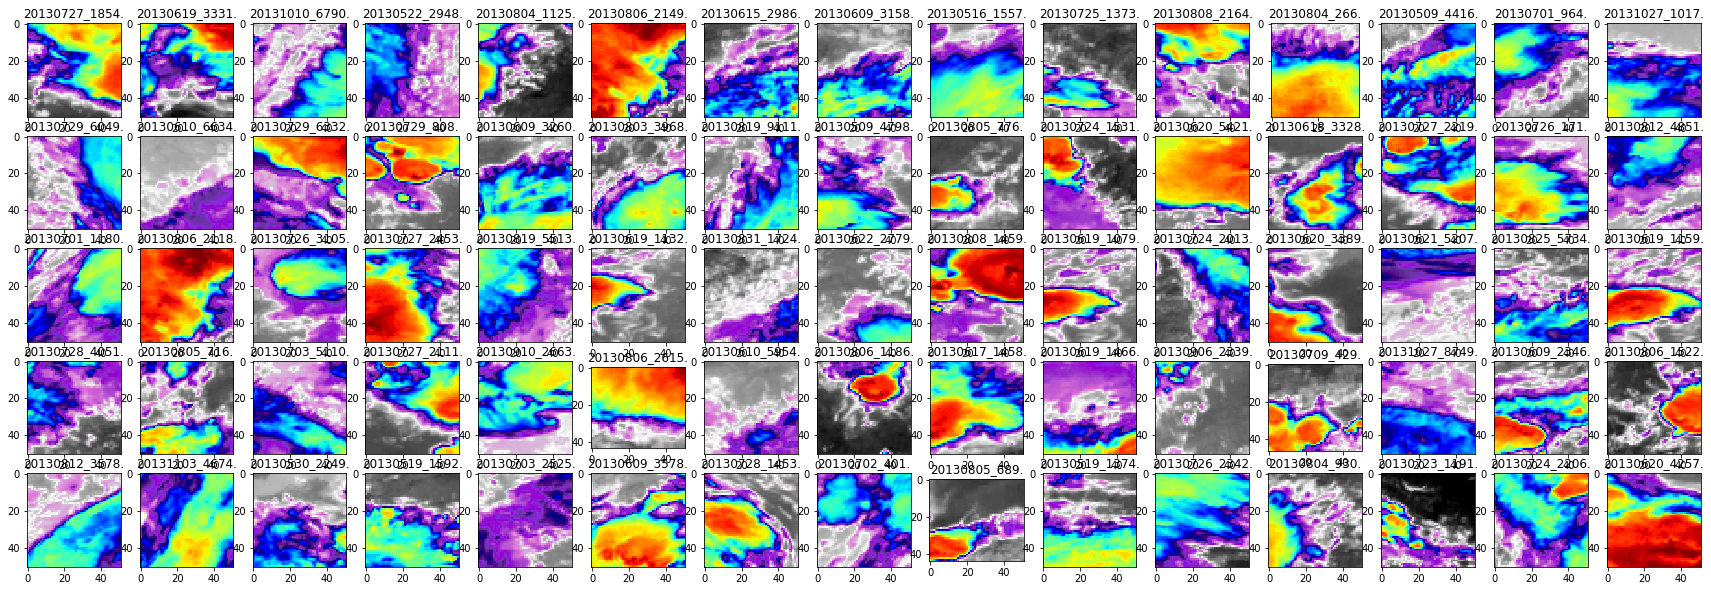

In [113]:
lc = len(sill_df[sill_df.cluster==4].cluster.values)
d = divisors(lc)

nrow = sorted(list(d))[len(list(d))//2]
ncol = lc // nrow

fig,ax = plt.subplots(ncol,nrow,figsize=(nrow*2,ncol*2))
axs = ax.ravel()

j = 0
for i, tr in tqdm.tqdm(sill_df[sill_df.cluster==4].iterrows(),total=lc):
    
    with xr.open_dataset("/vols/satellite/home/lenk/data/HACI_track_data/track_{}nc".format(tr.loc['id'])) as file:
        ir108 = file.ir108.data[6]
        
    axs[j].imshow(ir108,vmin=210,vmax=300,cmap=emap)
    axs[j].set_title(tr.id)
    
    j += 1

In [ ]:
lc = len(sill_df[_df.cluster==3].cluster.values)
d = divisors(lc)

nrow = sorted(list(d))[len(list(d))//2]
ncol = lc // nrow

fig,ax = plt.subplots(ncol,nrow,figsize=(nrow*2,ncol*2))
axs = ax.ravel()

j = 0
for i, tr in tqdm.tqdm(sill_df[sill_df.cluster==3].iterrows(),total=lc):
    
    with xr.open_dataset("/vols/satellite/home/lenk/data/HACI_track_data/track_{}.nc".format(tr.loc['id'])) as file:
        ir108 = file.ir108.data[6]
        
    axs[j].imshow(ir108,vmin=210,vmax=300,cmap=emap)
    axs[j].set_title(tr.id)
    
    j += 1

In [112]:
sill_df[(sill_df.cl <= .9) & (sill_df.sill<=10000)].to_csv("/vols/satellite/home/lenk/proj/2019-01_trackingstudie/data/interesting_haci_cases-2012-2014.csv",index=False)

In [117]:
lc = len(sill_df[(sill_df.cl <= .8) & (sill_df.sill<=1000)].cluster.values)

for i, tr in tqdm.tqdm(sill_df[(sill_df.cl <= .8) & (sill_df.sill<=1000)].iterrows(),total=lc):
    
    with xr.open_dataset("/vols/satellite/home/lenk/data/HACI_track_data/track_{}.nc".format(tr.loc['id'])) as file:
        ir108 = file.ir108.data[6]
        
    fig,ax = plt.subplots(1,1,figsize=(4,4))    
    ax.imshow(ir108,vmin=210,vmax=300,cmap=emap)
    ax.set_title(tr.loc['id'])
    plt.savefig("/vols/satellite/home/lenk/proj/2019-01_trackingstudie/pics/interesting_haci_cases-2012-2014/{}_var_{}.png".format(tr.loc['id'],
                                                                                                         int(np.rint(tr.loc['sill']))))
    plt.close()
    #j += 1



  0%|          | 0/490 [00:00<?, ?it/s]

  0%|          | 1/490 [00:00<01:22,  5.94it/s]

  0%|          | 2/490 [00:00<01:22,  5.93it/s]

  1%|          | 3/490 [00:00<01:36,  5.02it/s]

  1%|          | 4/490 [00:00<01:33,  5.22it/s]

  1%|          | 5/490 [00:00<01:28,  5.49it/s]

  1%|          | 6/490 [00:01<01:28,  5.44it/s]

  1%|▏         | 7/490 [00:01<01:28,  5.47it/s]

  2%|▏         | 8/490 [00:01<01:24,  5.68it/s]

  2%|▏         | 9/490 [00:01<01:22,  5.80it/s]

  2%|▏         | 10/490 [00:01<01:23,  5.77it/s]

  2%|▏         | 11/490 [00:01<01:22,  5.83it/s]

  2%|▏         | 12/490 [00:02<01:20,  5.92it/s]

  3%|▎         | 13/490 [00:02<01:33,  5.10it/s]

  3%|▎         | 14/490 [00:02<01:31,  5.22it/s]

  3%|▎         | 15/490 [00:02<01:29,  5.30it/s]

  3%|▎         | 16/490 [00:02<01:26,  5.48it/s]

  3%|▎         | 17/490 [00:03<01:23,  5.68it/s]

  4%|▎         | 18/490 [00:03<01:22,  5.69it/s]

  4%|▍         | 19/490 [00:03<01:22,  5.72it/s]

  4%|▍         |

 59%|█████▉    | 288/490 [01:10<00:37,  5.37it/s]

 59%|█████▉    | 289/490 [01:10<00:36,  5.52it/s]

 59%|█████▉    | 290/490 [01:11<00:35,  5.64it/s]

 59%|█████▉    | 291/490 [01:11<00:35,  5.61it/s]

 60%|█████▉    | 292/490 [01:11<00:34,  5.77it/s]

 60%|█████▉    | 293/490 [01:11<00:33,  5.81it/s]

 60%|██████    | 294/490 [01:11<00:34,  5.62it/s]

 60%|██████    | 295/490 [01:12<00:34,  5.60it/s]

 60%|██████    | 296/490 [01:12<00:34,  5.59it/s]

 61%|██████    | 297/490 [01:12<00:35,  5.42it/s]

 61%|██████    | 298/490 [01:12<00:34,  5.53it/s]

 61%|██████    | 299/490 [01:12<00:33,  5.64it/s]

 61%|██████    | 300/490 [01:12<00:33,  5.74it/s]

 61%|██████▏   | 301/490 [01:13<00:32,  5.83it/s]

 62%|██████▏   | 302/490 [01:13<00:31,  5.90it/s]

 62%|██████▏   | 303/490 [01:13<00:31,  5.96it/s]

 62%|██████▏   | 304/490 [01:13<00:30,  6.06it/s]

 62%|██████▏   | 305/490 [01:13<00:30,  6.04it/s]

 62%|██████▏   | 306/490 [01:13<00:30,  5.95it/s]

 63%|██████▎   | 307/490 [01:14